# ============================
# = Glazsiou study | 0 years since diagnosis =
# ============================

The purpose of this notebook is to perform all the analysis and visualisation to support the acaedmic article entitled "Visual analysis of the patterns of testing and treatment of type 2 diabetes that do not add value". The notebook is coded entirely in R.

# Get requisite packages.

In [1]:
# Get requisite packages.
if( !"pacman" %in% installed.packages() )
{
  install.packages( "pacman" )
  libray( pacman )
}
pacman::p_load(
    bigrquery # Version ‘1.5.1’
    ,data.table # Version ‘1.16.0’
    ,GGally # Version ‘2.2.1’
    ,ggraph
    ,gtable # Version ‘0.3.6’
    ,grid # Version ‘4.4.1’
    ,gridExtra # Version ‘2.3’
    ,IRdisplay
    ,kableExtra
    ,paletteer # Version ‘1.6.0’
    ,readr # Version ‘2.1.5’
    ,tidytext # Version ‘0.4.2’
    ,tidyverse # Version ‘2.0.0’
    ,TraMineR # Version ‘2.2.10’
    ,TraMineRextras # Version ‘0.6.8’
)
#devtools::install_github("davidsjoberg/ggsankey")
#remove.packages("ggsankey")
devtools::install_github("ciaranmci/ggsankey", force = TRUE )


── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/var/tmp/RtmpQNre4k/remotesc5b61692db0/ciaranmci-ggsankey-821b0e3/DESCRIPTION’ ... OK
* preparing ‘ggsankey’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘ggsankey_0.0.99999.tar.gz’



Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



# Set cohort parameters

In [2]:
# Study dates
# ## The date before which a patient must have had their diagnosis.
date_diagnosis_threshold <- lubridate::ymd('2000-01-01')
# ## The date after which test and intervention records will be studied.
followup_delay_in_years <- 0
date_followup_start <- date_diagnosis_threshold + lubridate::years( followup_delay_in_years )
# ## The date before which test and intervention records will be studied.
followup_duration_in_years <- 10
date_followup_end <- date_followup_start + lubridate::years( followup_duration_in_years )

# Set the duration of the window back in time to review prescriptions when identifying
# the HMA status.
HMA_adjust_lookBack_window <- lubridate::weeks( 16 )

# Set upper and lower thresholds for acceptable values of the test.
test_value_cutoff_lower <- 20
test_value_cutoff_upper <- 200

# Threshold for the expected interval between subsequent tests, in months
val_testing_interval_LB <- 2
val_testing_interval_UB <- 5

# Set values for meaningful changes in the values of the test.
val_meaningful_test_improvement <- -10
val_meaningful_test_disimprovement <- 10

# Set window within which to search for repeated (but not repeat) prescriptions.
window_repeated_prescription_months <- 3

# Set number of tests, treatments, or iterations after diagnosis that should be tracked.
n_iterations <- followup_duration_in_years*2

# Set the window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months.
multimorb_inclusion_window_months <- 60

# Set the window outwith which at least two mutimorbidity diagnoses must be of each other, in months.
multimorb_gap_window_months <- 1

# Generate the cohort.

In [3]:
source('RESHAPE_cohort_generator.r')

Warning message:
“The `check_from` argument of `tbl_sql()` is deprecated as of dbplyr 2.5.0.
ℹ The deprecated feature was likely used in the dbplyr package.
  Please report the issue at <https://github.com/tidyverse/dbplyr/issues>.”
Warning message:
“Missing values are always removed in SQL aggregation functions.
Use `na.rm = TRUE` to silence this warning
This warning is displayed once every 8 hours.”


# Format the data.

In [4]:
source('RESHAPE_format_the_data.r')

`summarise()` has grouped output by 'person_id'. You can override using the
`.groups` argument.


# Create STS objects.

In [5]:
source('RESHAPE_create_STS_objects.r')

# Summary of parameter values.

In [6]:
paste( date_diagnosis_threshold,": The date before which a patient must have had their diagnosis." )
paste( followup_delay_in_years,": The follow-up delay, in years." )
paste( followup_duration_in_years,": The follow-up duration, in years." )
paste( date_followup_start,": The date after which test and intervention records will be studied." )
paste( date_followup_end,": The date before which test and intervention records will be studied." )
paste( HMA_adjust_lookBack_window, ": The duration of the window, backward in time, to review prescriptions when identifying the state of the inter-test period.")
paste( test_value_cutoff_lower,": Lower threshold for acceptable values of the test." )
paste( test_value_cutoff_upper,": Upper threshold for acceptable values of the test." )
paste( window_repeated_prescription_months, ": The window within which to search for repeated (but not repeat) prescriptions.")
paste( n_iterations,": Number of tests, treatments,or iteration after diagnosis that should be tracked." )
paste( multimorb_inclusion_window_months,": The window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months." )
paste( multimorb_gap_window_months,": The window outwith which at least two mutimorbidity diagnoses must be of each other, in months." )


[1] "2000-01-01 : The date before which a patient must have had their diagnosis."

[1] "0 : The follow-up delay, in years."

[1] "10 : The follow-up duration, in years."

[1] "2000-01-01 : The date after which test and intervention records will be studied."

[1] "2010-01-01 : The date before which test and intervention records will be studied."

[1] "112d 0H 0M 0S : The duration of the window, backward in time, to review prescriptions when identifying the state of the inter-test period."

[1] "20 : Lower threshold for acceptable values of the test."

[1] "200 : Upper threshold for acceptable values of the test."

[1] "3 : The window within which to search for repeated (but not repeat) prescriptions."

[1] "20 : Number of tests, treatments,or iteration after diagnosis that should be tracked."

[1] "60 : The window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months."

[1] "1 : The window outwith which at least two mutimorbidity diagnoses must be of each other, in months."

# Sankey plots

<b>Note: The Sankey plots show data that are in <u>ST</u>ate <u>S</u>equence format. This means that:</b>

1. <b>the number of sequence steps is decided by the maximum number of sequence steps observed across the dataset,</b>

2. <b>test events that are lost to follow-up are coded as 'Unobserved', _and_</b>

3. <b>the Sankey diagrams that include unobserved test events assume that the person maintains their most-recent value. This is misleading.<b>
<br>
<br>
<br>
<br>



#### Test Statuses
First, I show a basic Sankey plot showing patients' test results at each testing event and visualise the proportion of patient records that switch between test statuses.

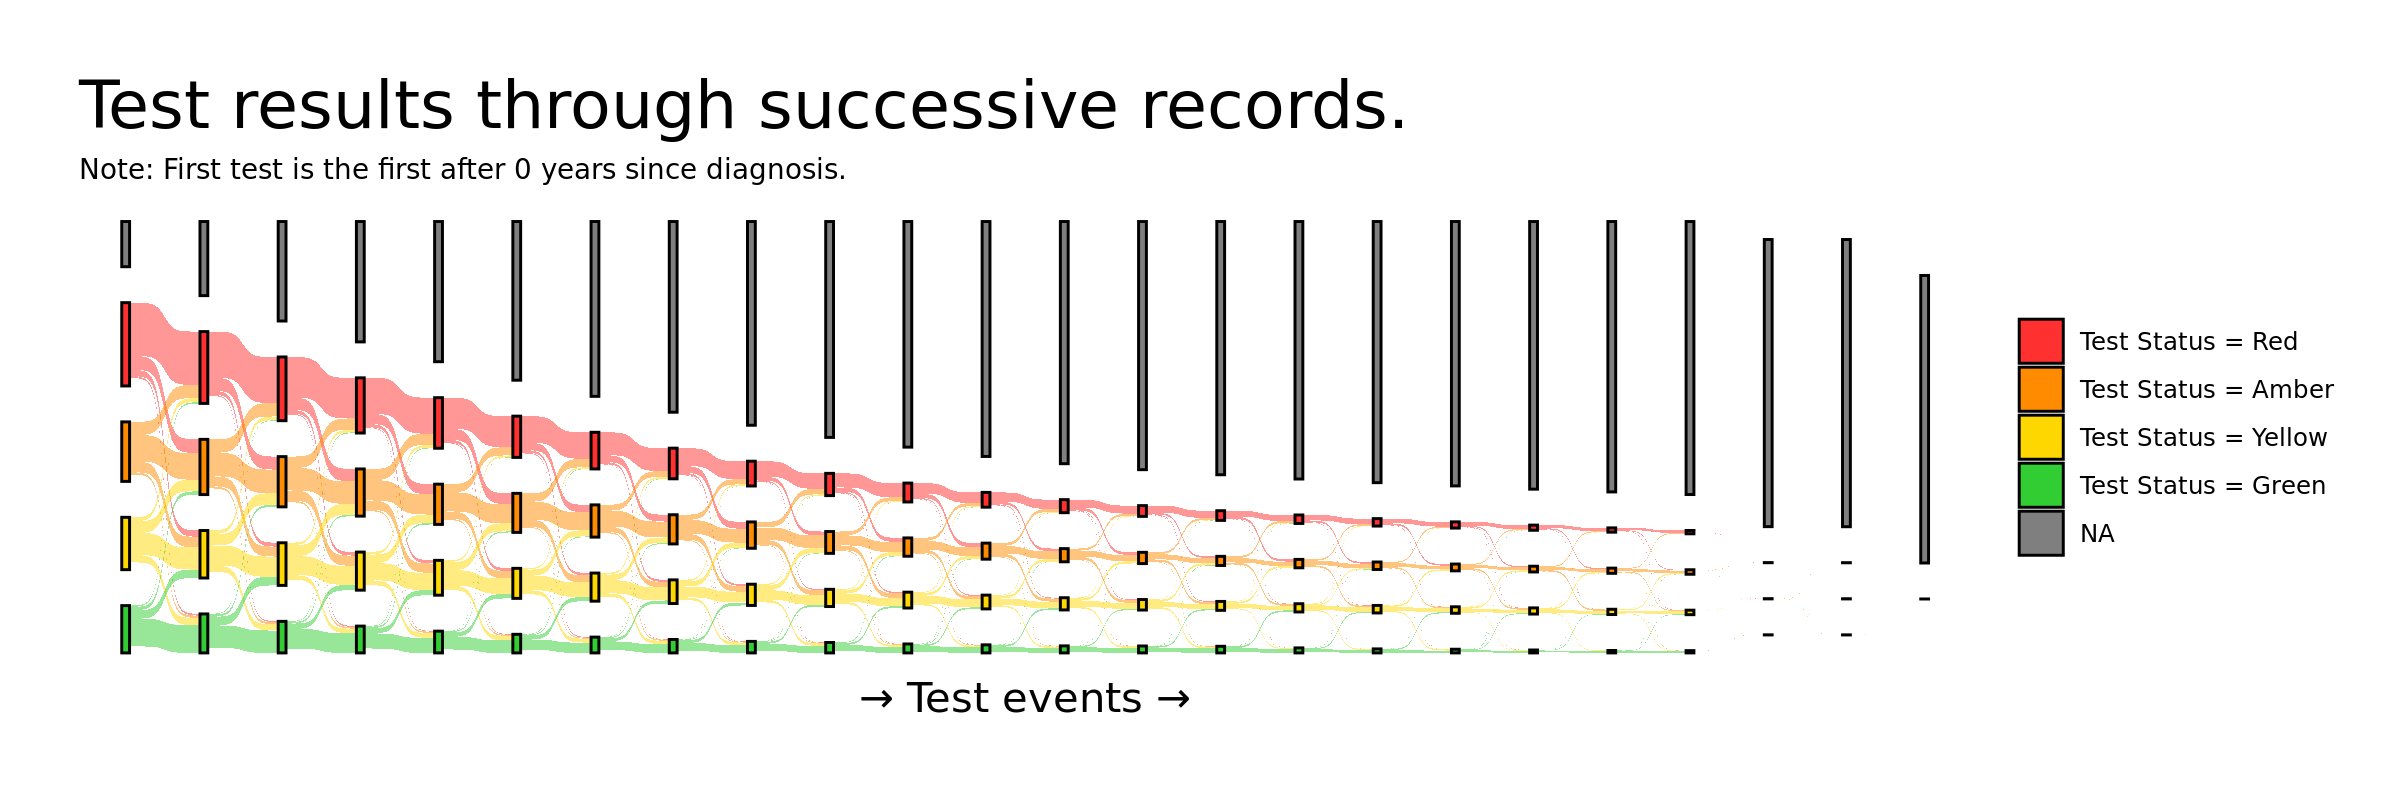

In [51]:
# Make plot data.
plotData <-
    sts_seqmine_test_only %>%
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_fct_order ) %>% droplevels() %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings()

# PLot.
options( repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200 )

plot_testStatus_Sankey_counts <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
#    ggsankey::geom_sankey_label(
#        aes(
#          x = as.numeric(x) + .05,
#          label = after_stat( paste0( freq ) )
#        ),
#        size = 8 / .pt, color = "white", fill = "gray40",
#        hjust = 0
#) +
    scale_fill_manual( values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull() ) +
    labs(
        title = "Test results through successive records."
        ,subtitle = paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.title = element_blank()
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

plot_testStatus_Sankey_counts

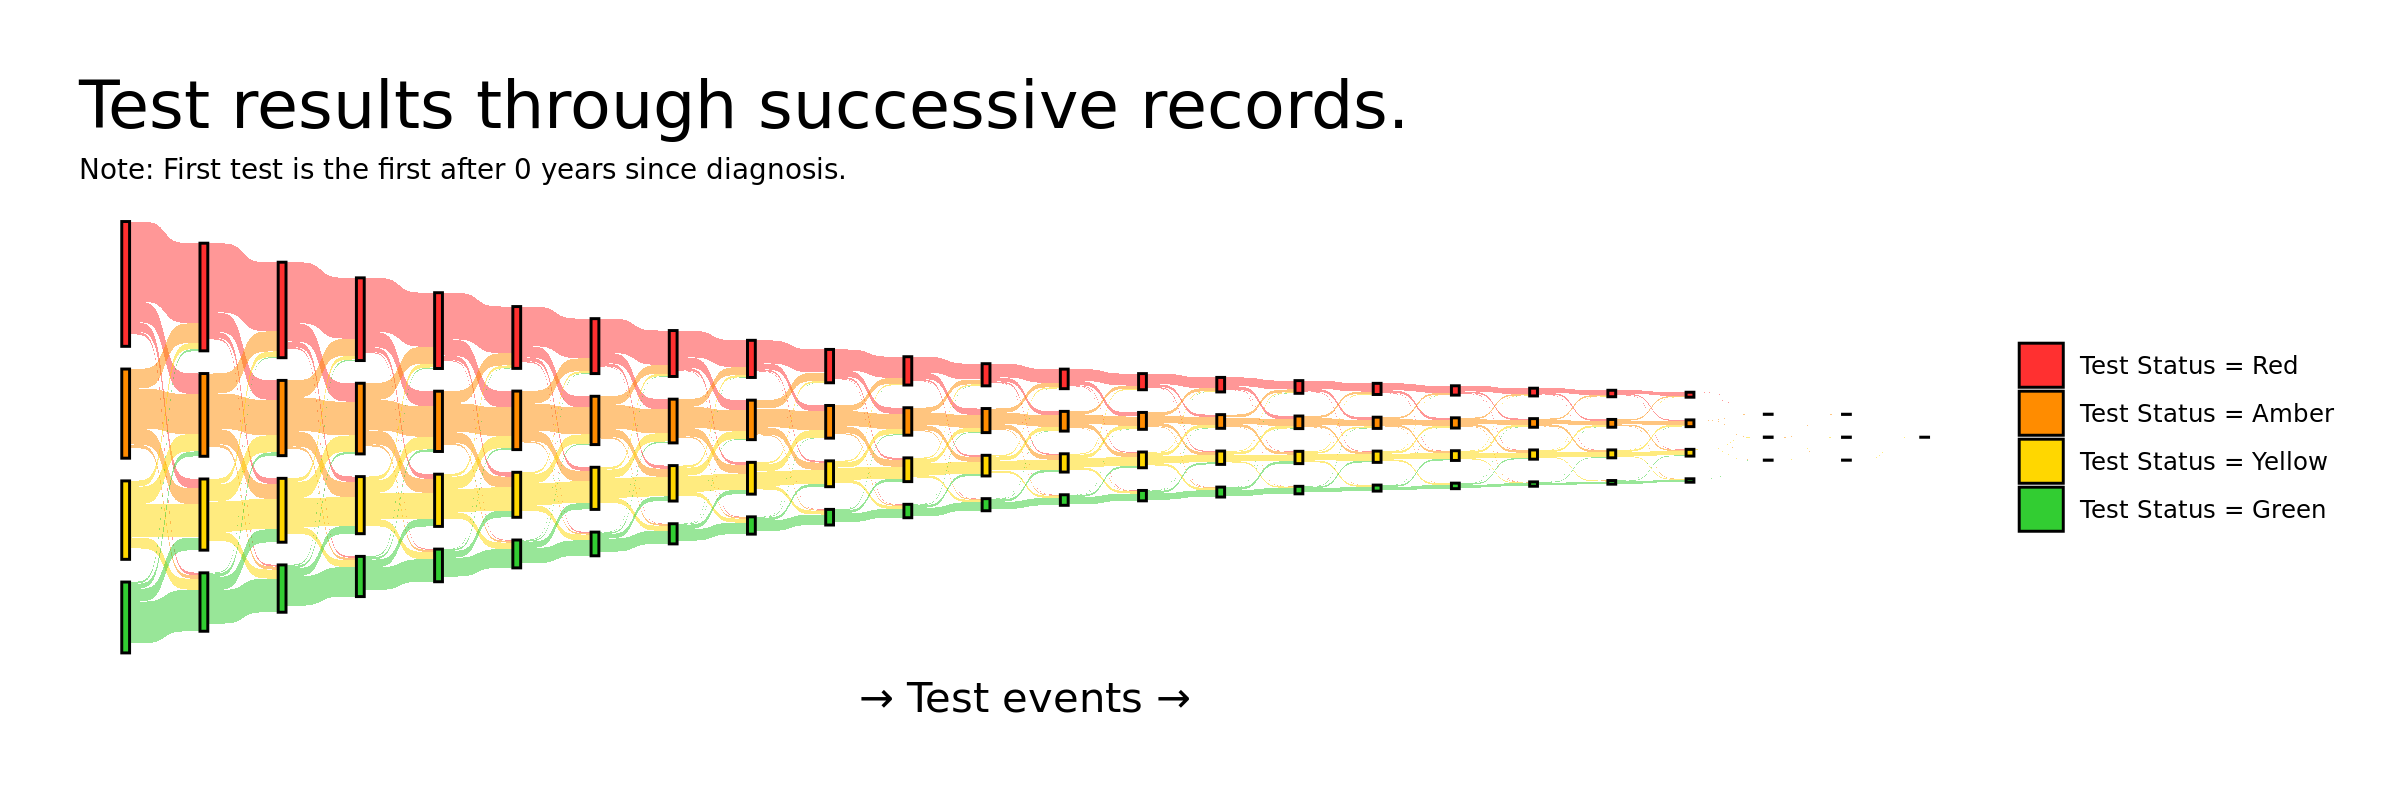

In [43]:
# Make plot data.
plotData <-
    sts_seqmine_test_only %>% 
    dplyr::select( -last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>% dplyr::select( event_fct_order ) %>% droplevels() %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings() %>%
    dplyr::mutate(
        node = dplyr::if_else( node == "Unobserved", NA, node )
        ,next_node = dplyr::if_else( next_node == "Unobserved", NA, next_node )
    ) %>%
    dplyr::filter( !is.na( node ) )


# PLot.
options( repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200 )

plot_testStatus_Sankey_narrowing <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1 ) +
    scale_fill_manual( values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull() ) +
    labs(
        title = "Test results through successive records."
        ,subtitle = paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.title = element_blank()
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

plot_testStatus_Sankey_narrowing

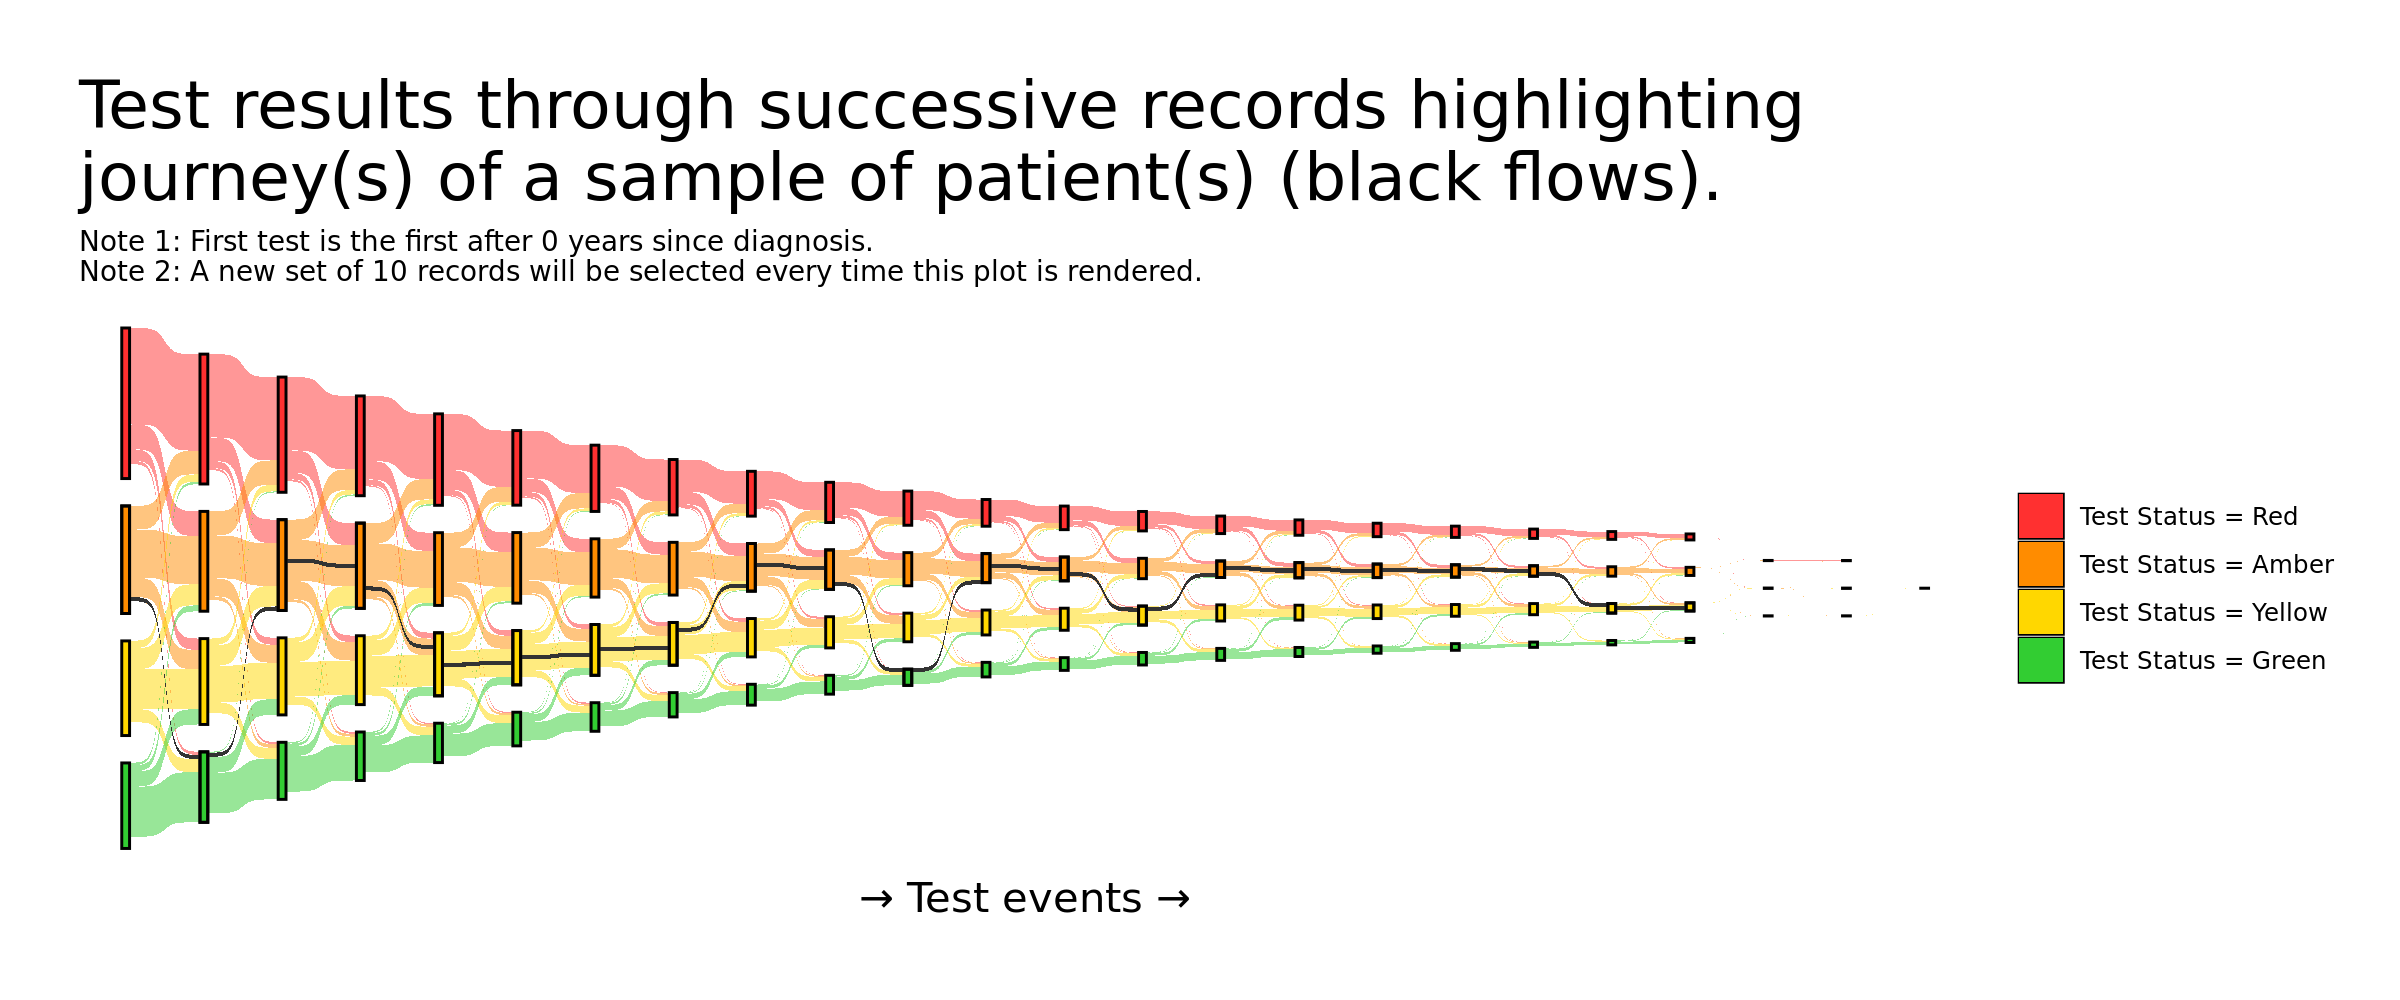

In [63]:
# Set plot parameters.
n_records_to_sample <- 10

# Make plot data.
plotData <-
    sts_seqmine_test_only %>%
    dplyr::select( -last_col() ) %>%
    #ggsankey::make_long( colnames( . ), subset.rowname = "00E929ADBFDDFD0B9036CA33AA404D5A25D55E8C1331182997930CEA4438820F" ) %>%
    ggsankey::make_long( colnames( . ), subset.logic = "random", n.random = n_records_to_sample ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>% dplyr::select( event_fct_order ) %>% droplevels() %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings() %>%
    dplyr::mutate(
        node = dplyr::if_else( node == "Unobserved", NA, node )
        ,next_node = dplyr::if_else( next_node == "Unobserved", NA, next_node )
    ) %>%
    dplyr::filter( !is.na( node ) )

# PLot.
options( repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200 )

plot_testStatus_Sankey_narrowing_highlight_journey <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1 ) +
    ggsankey::geom_sankey_subset( mapping = ggplot2::aes( subset.idx = subset.idx ), range.scalar = 0.1 ) +
    scale_fill_manual( values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull() ) +
    labs(
        title = "Test results through successive records highlighting\njourney(s) of a sample of patient(s) (black flows)."
        ,subtitle = paste0(
            "Note 1: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.\n"
            ,"Note 2: A new set of ", n_records_to_sample," records will be selected every time this plot is rendered."
        )
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.title = element_blank()
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

plot_testStatus_Sankey_narrowing_highlight_journey

Some observations from the Test Statuses Sankey diagram:

1. __The relative proportions of patients in each test status remains approximately constant through test events.__
    - Evidenced by little variation in the height of the vertical bars in the plots of proportions over time.
<br></br>

2. __There are fewer health records with longer sequences of test events.__
    - Evidenced by the narrowing of the unscaled proportions plots, and by the increase in 'Unobserved' state in the count plot.
<br></br>

3. __The test statuses that change between every test event rarely change by more than one level.__
    - Evidenced by the barely-visible flows linking bars at subsequent test points that are not vertically adjacent.

#### States strata

In the next plots, I visualise the counts and proportions of patient records moving between states.

State stratification is based on and idea by CB. There are three infomed by two components: the testing interval since the previous test {'Expected', 'Shorter-than-expected'}, and the change in prescriptions compared with the previous testing interval {'No observed change', 'Observed change'}. The three states are (0,0)-"Hold"; (1,0)-"Monitor"; (0 or 1,1)-"Adjust".

We tried to map these states to [Glasziou, Irwig, and Mant (2005)](https://www.bmj.com/content/330/7492/644.long) who wrote about "In control", "Remeasure", and "Action", but they didn't quite fit.

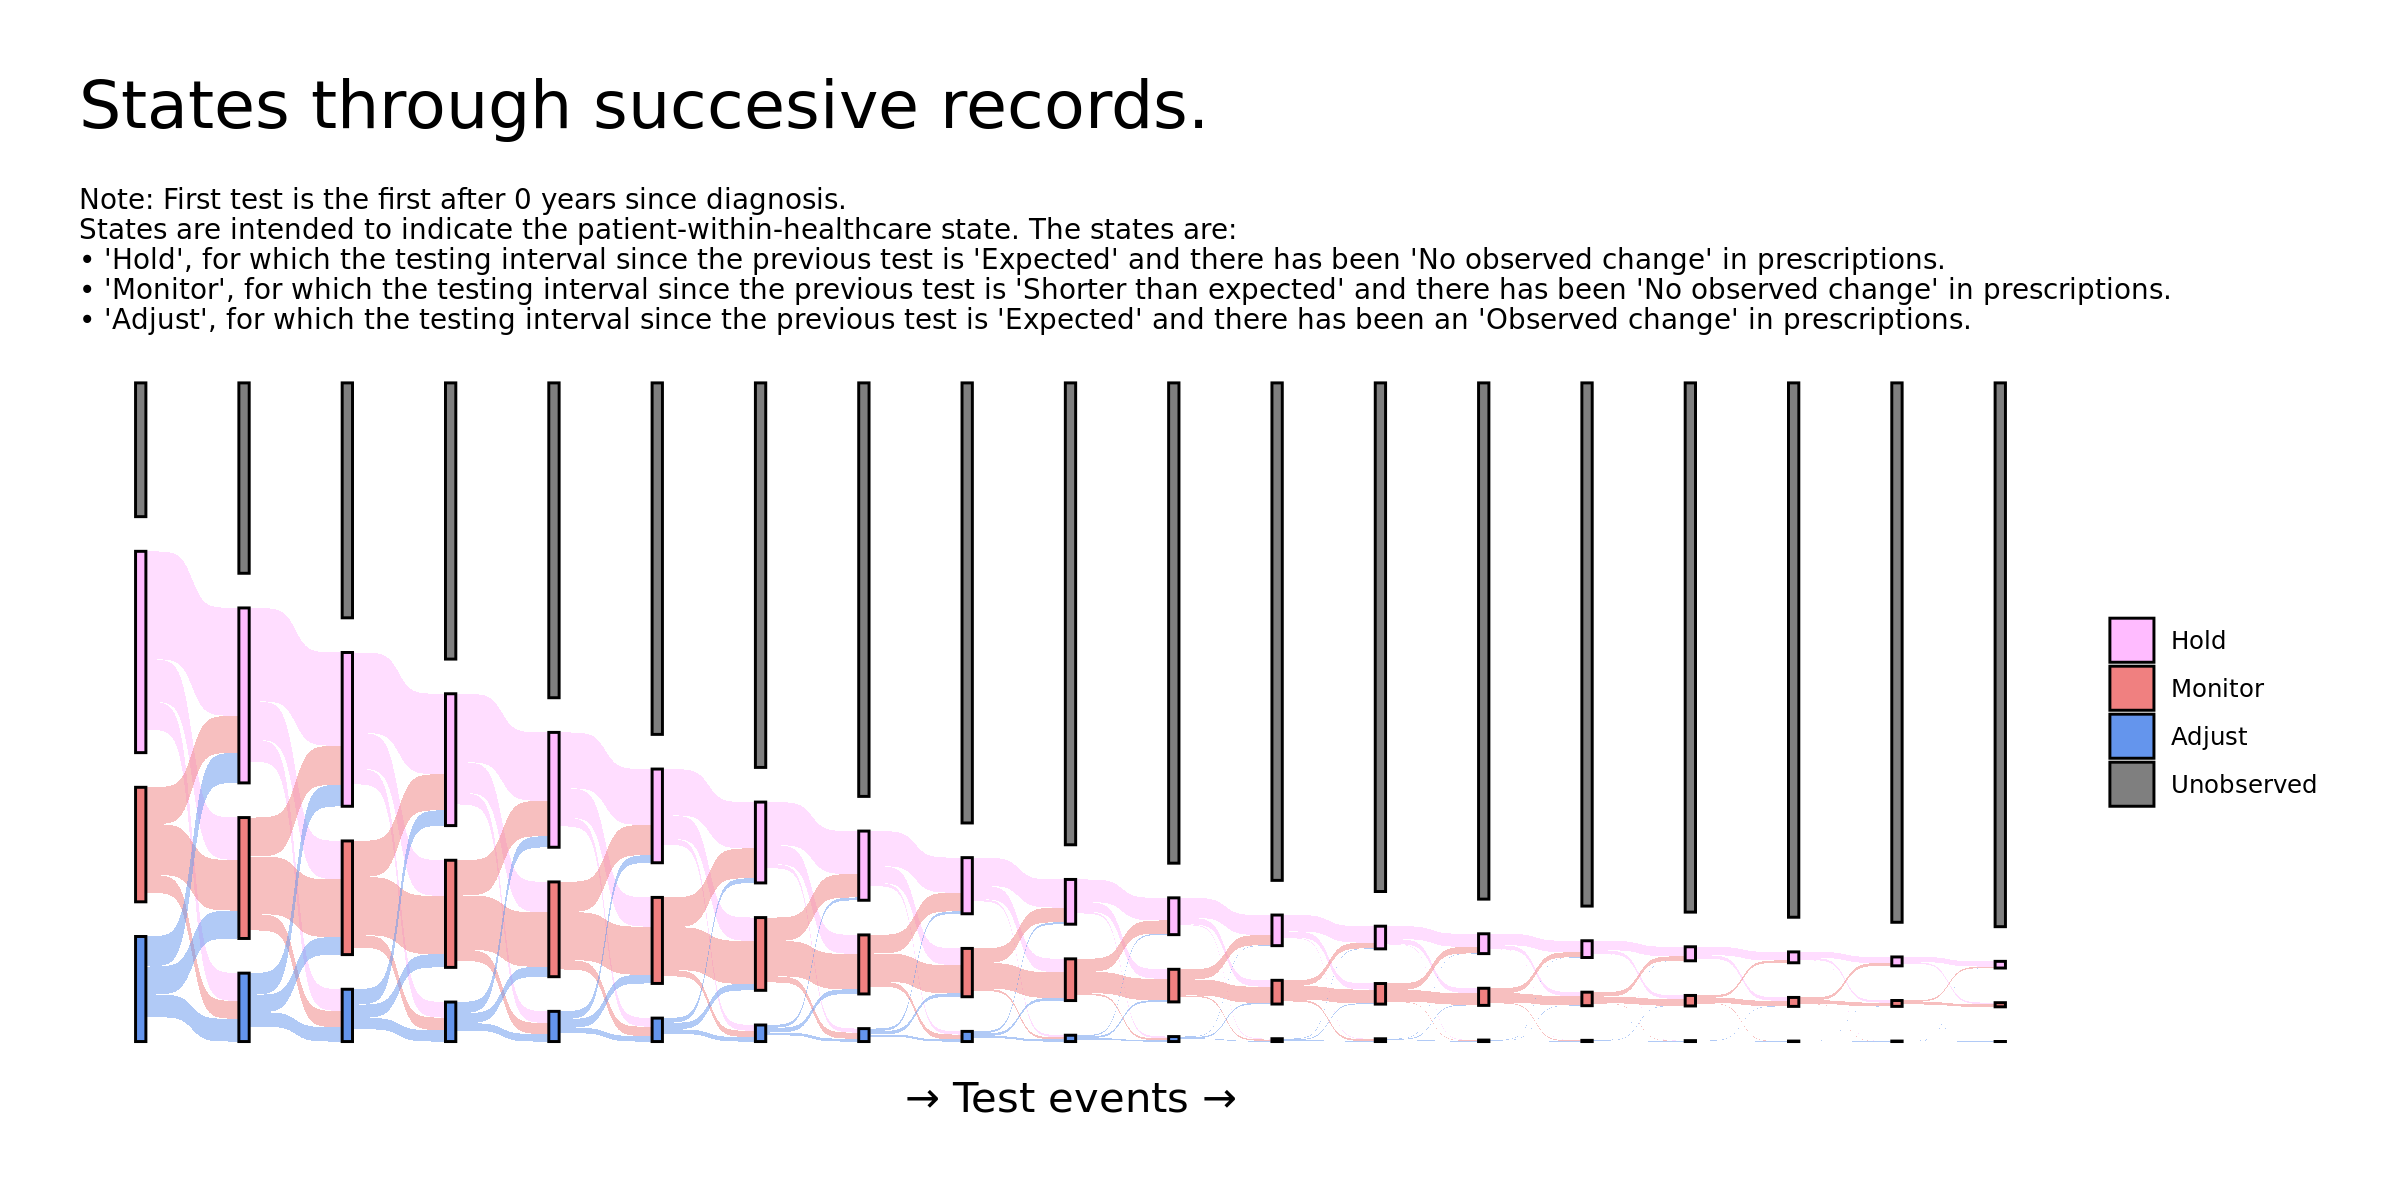

In [61]:
# Make plot data.
plotData <-
    sts_seqmine_HMA %>%
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMA_factor %>% dplyr::distinct( HMA_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings()

# Plot.
options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

plot_HMA_Sankey_counts <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
#    ggsankey::geom_sankey_label(
#        aes(
#          x = as.numeric(x) + .05,
#          label = after_stat(paste0(freq))
#        ),
#        size = 8 / .pt, color = "white", fill = "gray40",
#        hjust = 0
#      ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual(
        values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
        ,labels = c( "Hold", "Monitor", "Adjust", "Unobserved" )
    ) +
    labs(
        title = "States through succesive records."
       ,subtitle = paste0(
            paste0("\nNote: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.\n")
            ,"States are intended to indicate the patient-within-healthcare state. The states are:\n"
            ,"\u2022 'Hold', for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Monitor', for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Adjust', for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        ,legend.title = element_blank()
        )

plot_HMA_Sankey_counts

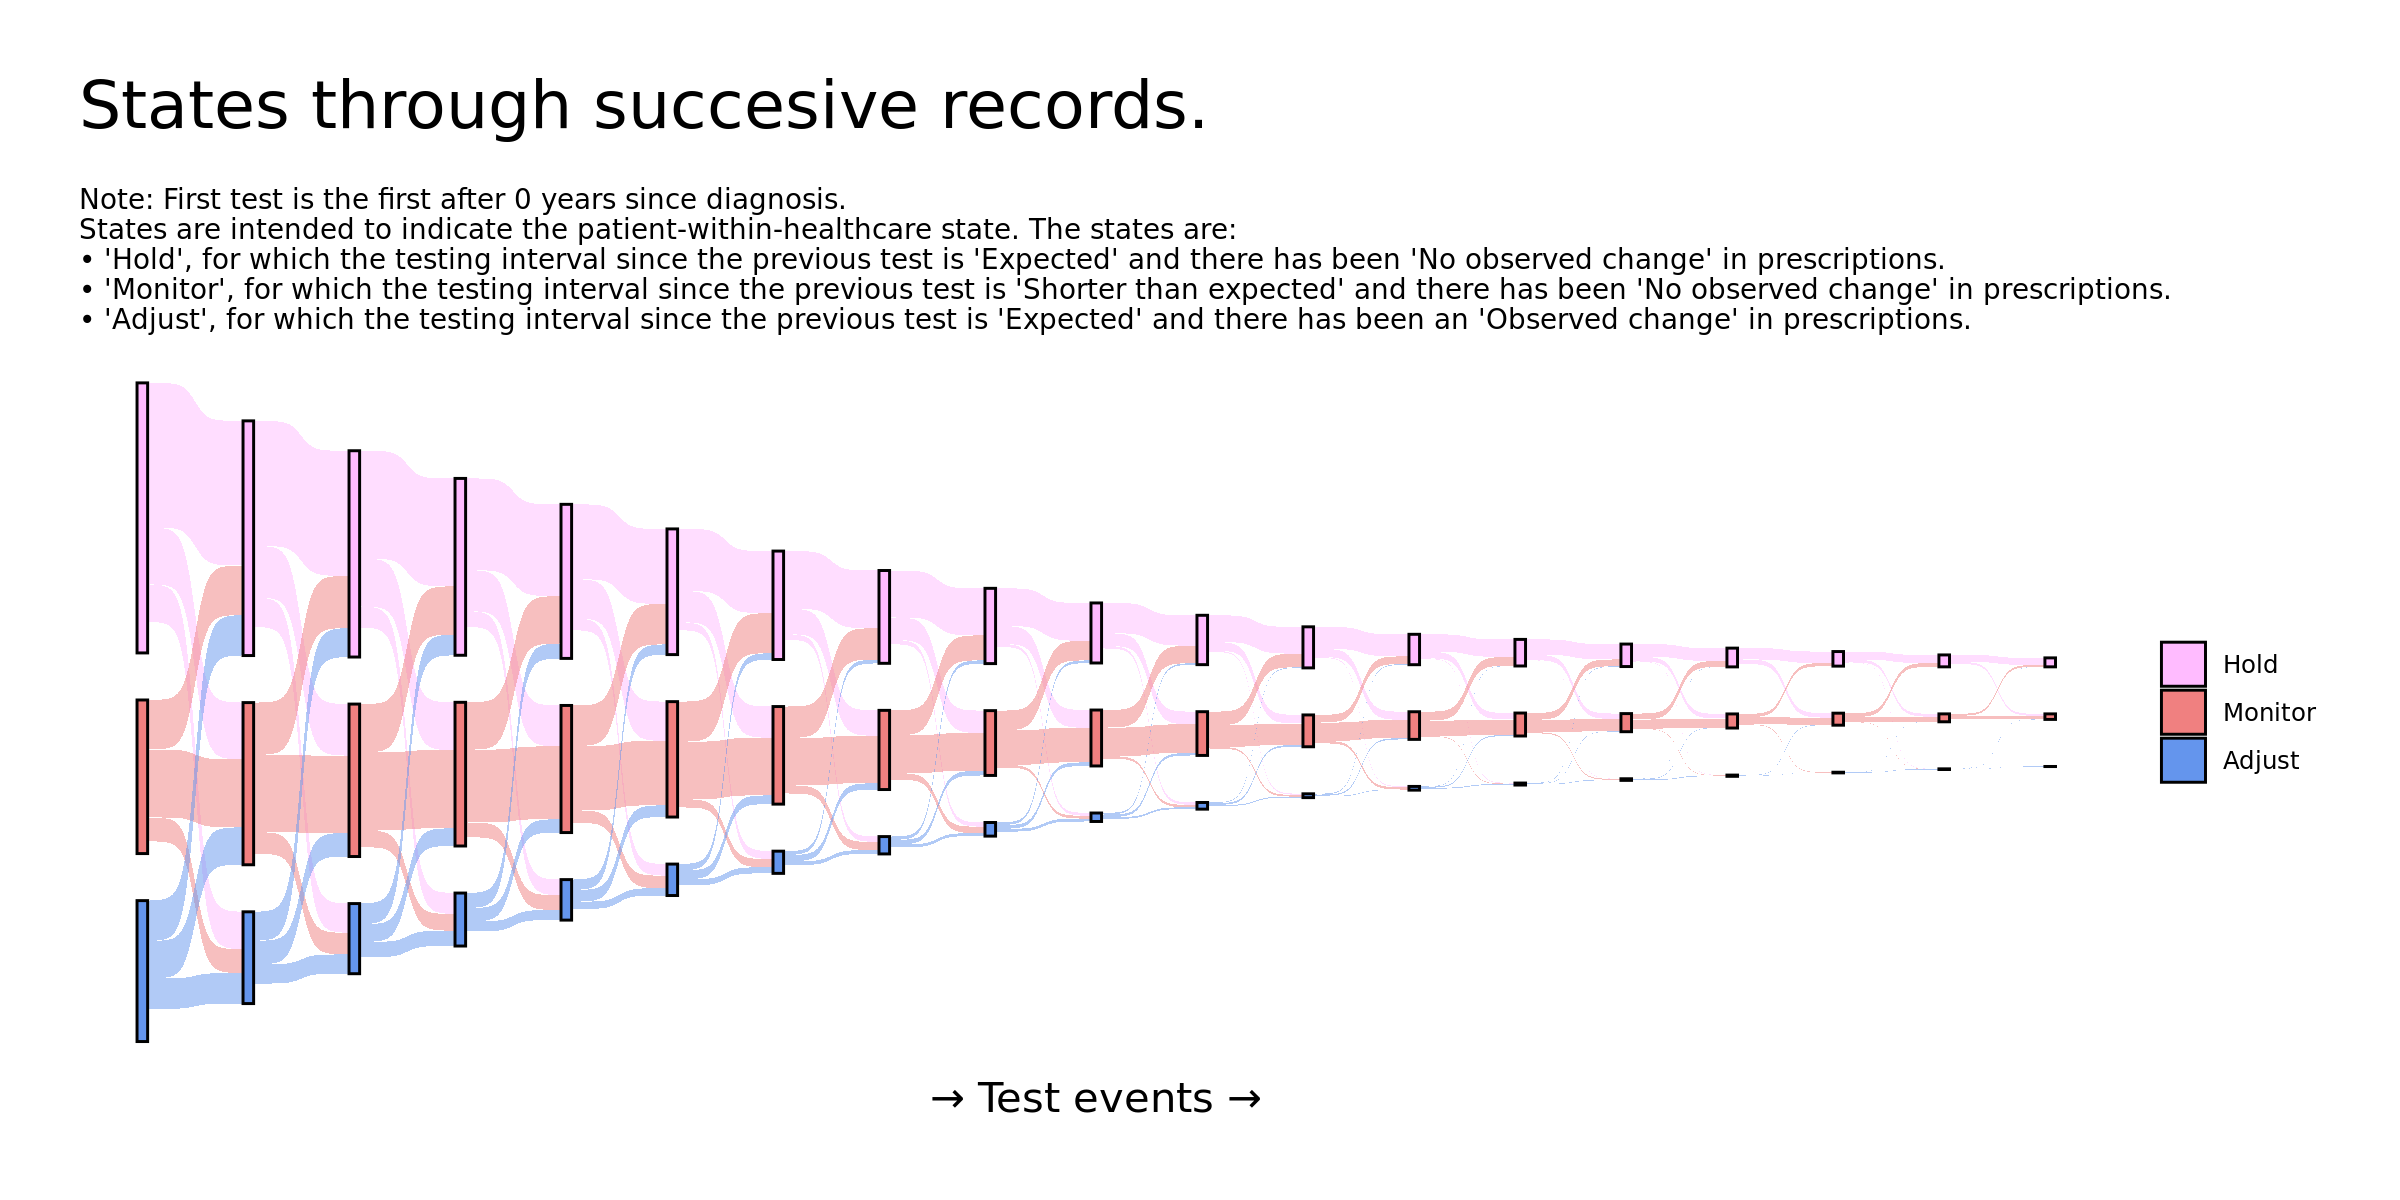

In [46]:
# Make plot data.
plotData <-
    sts_seqmine_HMA %>%
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMA_factor %>% dplyr::distinct( HMA_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings() %>%
    dplyr::mutate(
        node = dplyr::if_else( node == "Unobserved", NA, node )
        ,next_node = dplyr::if_else( next_node == "Unobserved", NA, next_node )
    ) %>%
    dplyr::filter( !is.na( node ) )

# Plot.
options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

plot_HMA_Sankey_narrowing <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual(
        values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
        ,labels = c( "Hold", "Monitor", "Adjust", "Unobserved" )
    ) +
    labs(
        title = "States through succesive records."
       ,subtitle = paste0(
            paste0("\nNote: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.\n")
            ,"States are intended to indicate the patient-within-healthcare state. The states are:\n"
            ,"\u2022 'Hold', for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Monitor', for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Adjust', for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        ,legend.title = element_blank()
        )

plot_HMA_Sankey_narrowing

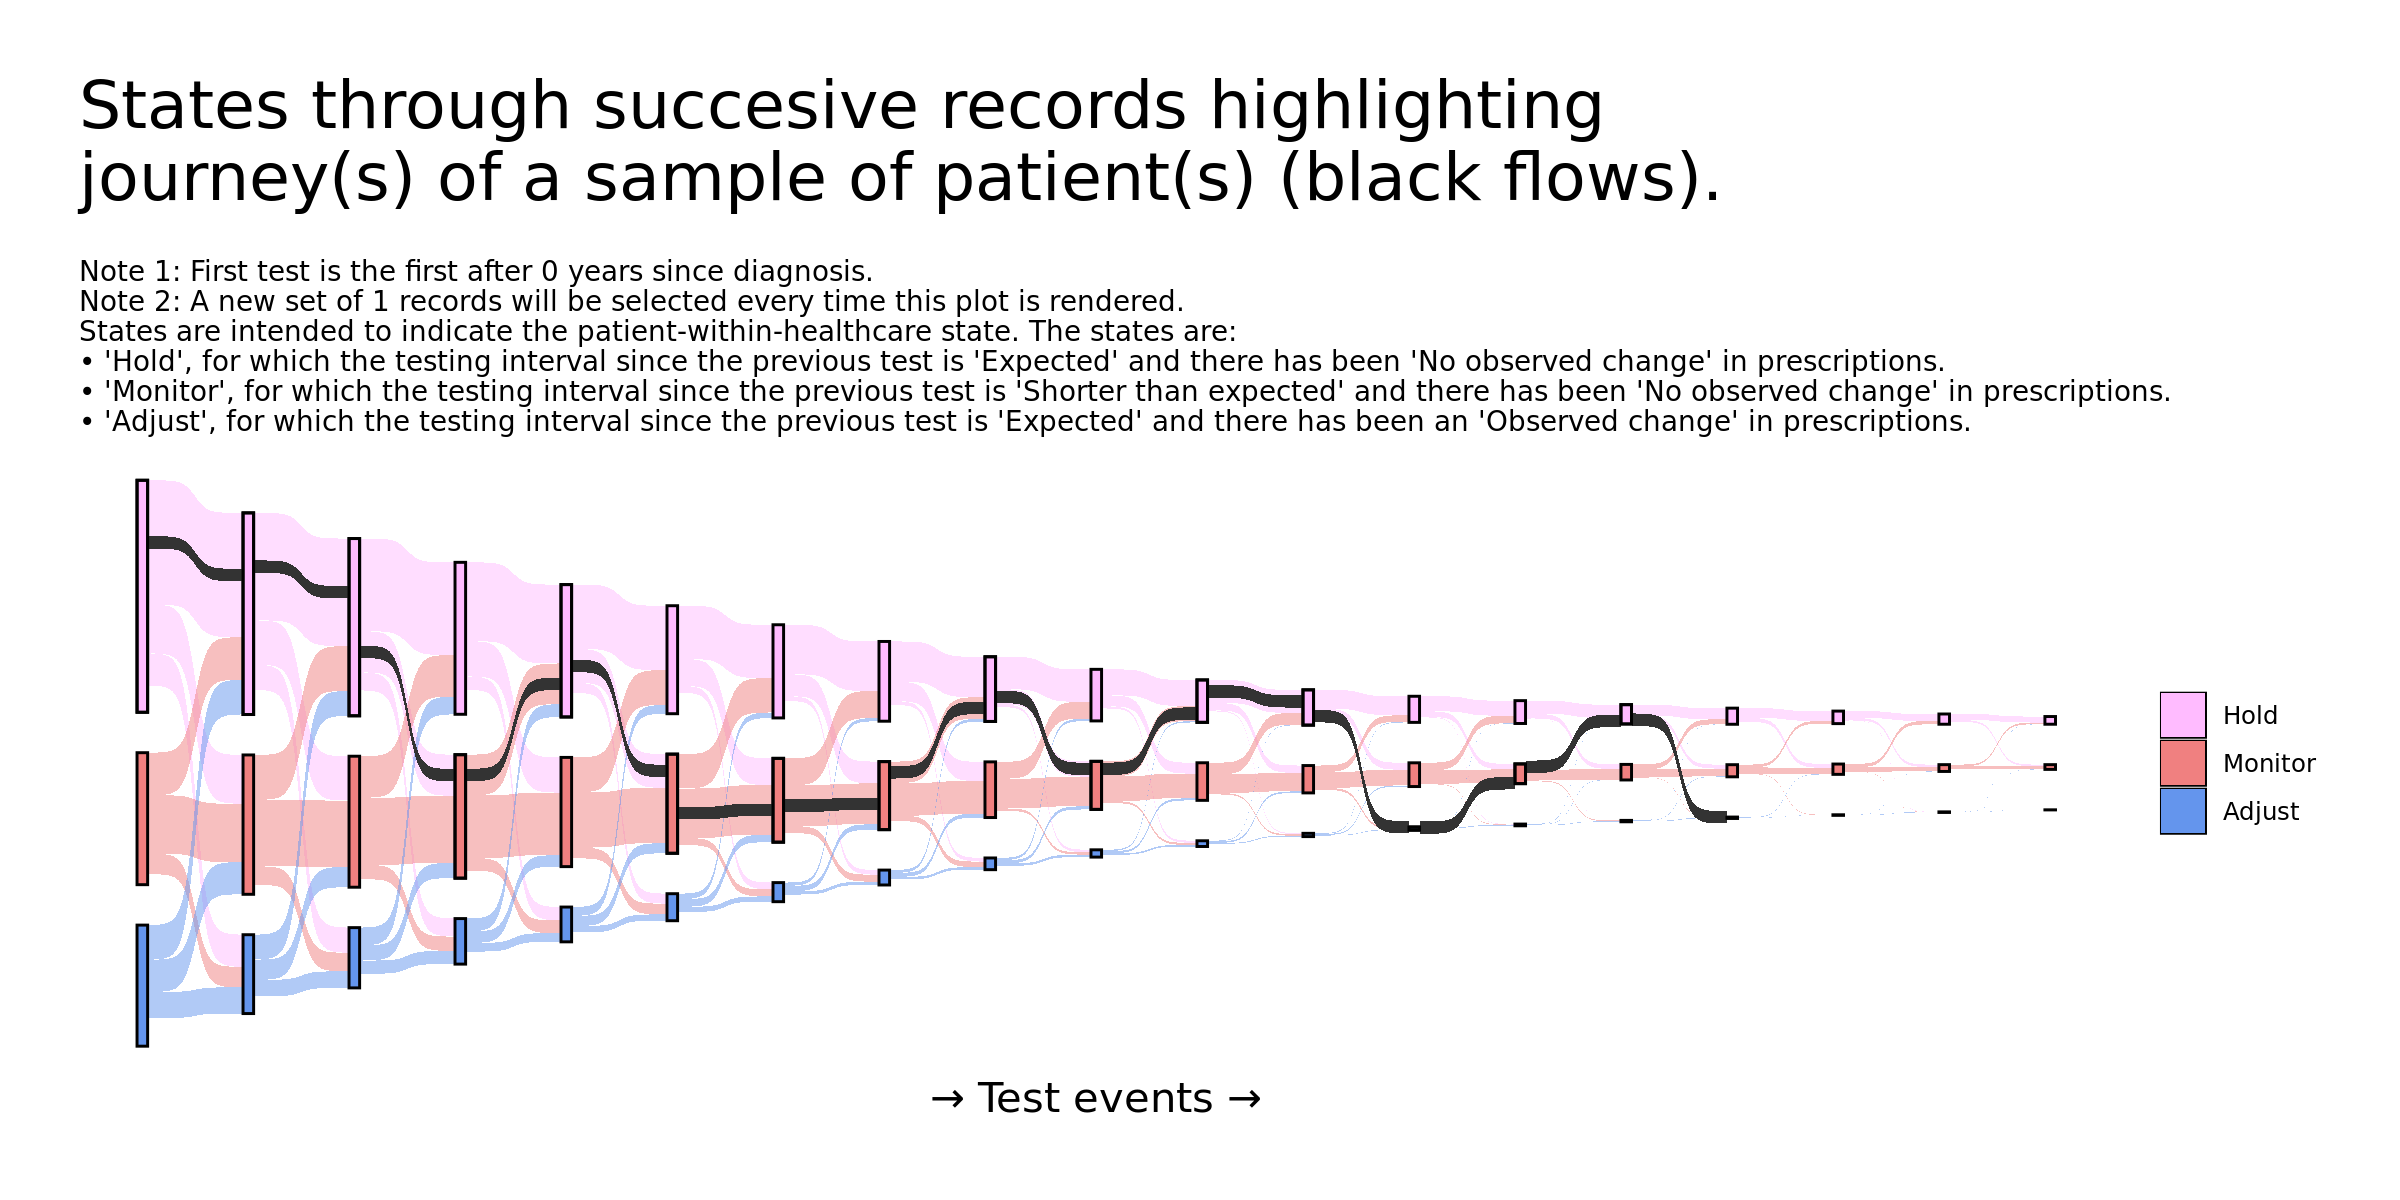

In [60]:
# Set plot parameters.
n_records_to_sample <- 1

# Make plot data.
plotData <-
    sts_seqmine_HMA %>%
    dplyr::select( - last_col() ) %>%
    #ggsankey::make_long( colnames( . ), subset.rowname = "00344F12A5F07646ABC66AE403552E9AE4E076706C710A52568AD022E98BAB26" ) %>%
    ggsankey::make_long( colnames( . ), subset.logic = "random", n.random = n_records_to_sample ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMA_factor %>% dplyr::distinct( HMA_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings() %>%
    dplyr::mutate(
        node = dplyr::if_else( node == "Unobserved", NA, node )
        ,next_node = dplyr::if_else( next_node == "Unobserved", NA, next_node )
    ) %>%
    dplyr::filter( !is.na( node ) )

# Plot.
options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

plot_HMA_Sankey_narrowing_highlight_journey <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
    ggsankey::geom_sankey_subset( mapping = ggplot2::aes( subset.idx = subset.idx ), range.scalar = 0.1 ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual(
        values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
        ,labels = c( "Hold", "Monitor", "Adjust", "Unobserved" )
    ) +
    labs(
        title = "States through succesive records highlighting\njourney(s) of a sample of patient(s) (black flows)."
       ,subtitle = paste0(
            paste0("\nNote 1: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.\n")
            ,"Note 2: A new set of ", n_records_to_sample," records will be selected every time this plot is rendered.\n"
            ,"States are intended to indicate the patient-within-healthcare state. The states are:\n"
            ,"\u2022 'Hold', for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Monitor', for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Adjust', for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        ,legend.title = element_blank()
        )

plot_HMA_Sankey_narrowing_highlight_journey

Some observations from the state Sankey diagram:

1. __The relative proportions of records in each state are consistently ordered from most in 'Hold' to least in 'Adjust'.__
    - Evidenced by the height of the 'Hold' bars always being the largest, and the 'Adjust' bars always being the shortest, at each test event.
<br></br>

2. __The most common changes in state are between the 'Hold' state and the 'Monitor' state.__
    - Evidenced by the largest flows between states being between 'Hold' and 'Monitor'.
<br></br>

3. __There are fewer health records with longer sequences of test events.__
    - Evidenced by the narrowing of the unscaled proportions plots, and by the increase in 'Unobserved' state in the count plot.
<br></br>

4. __The test statuses that change between every test event rarely change by more than one level.__
    - Evidenced by the barely-visible flows linking bars at subsequent test points that are not vertically adjacent.

#### Test Status and State strata

In the next plots, I visualise the counts and proportions of patient records moving through test statues and state.

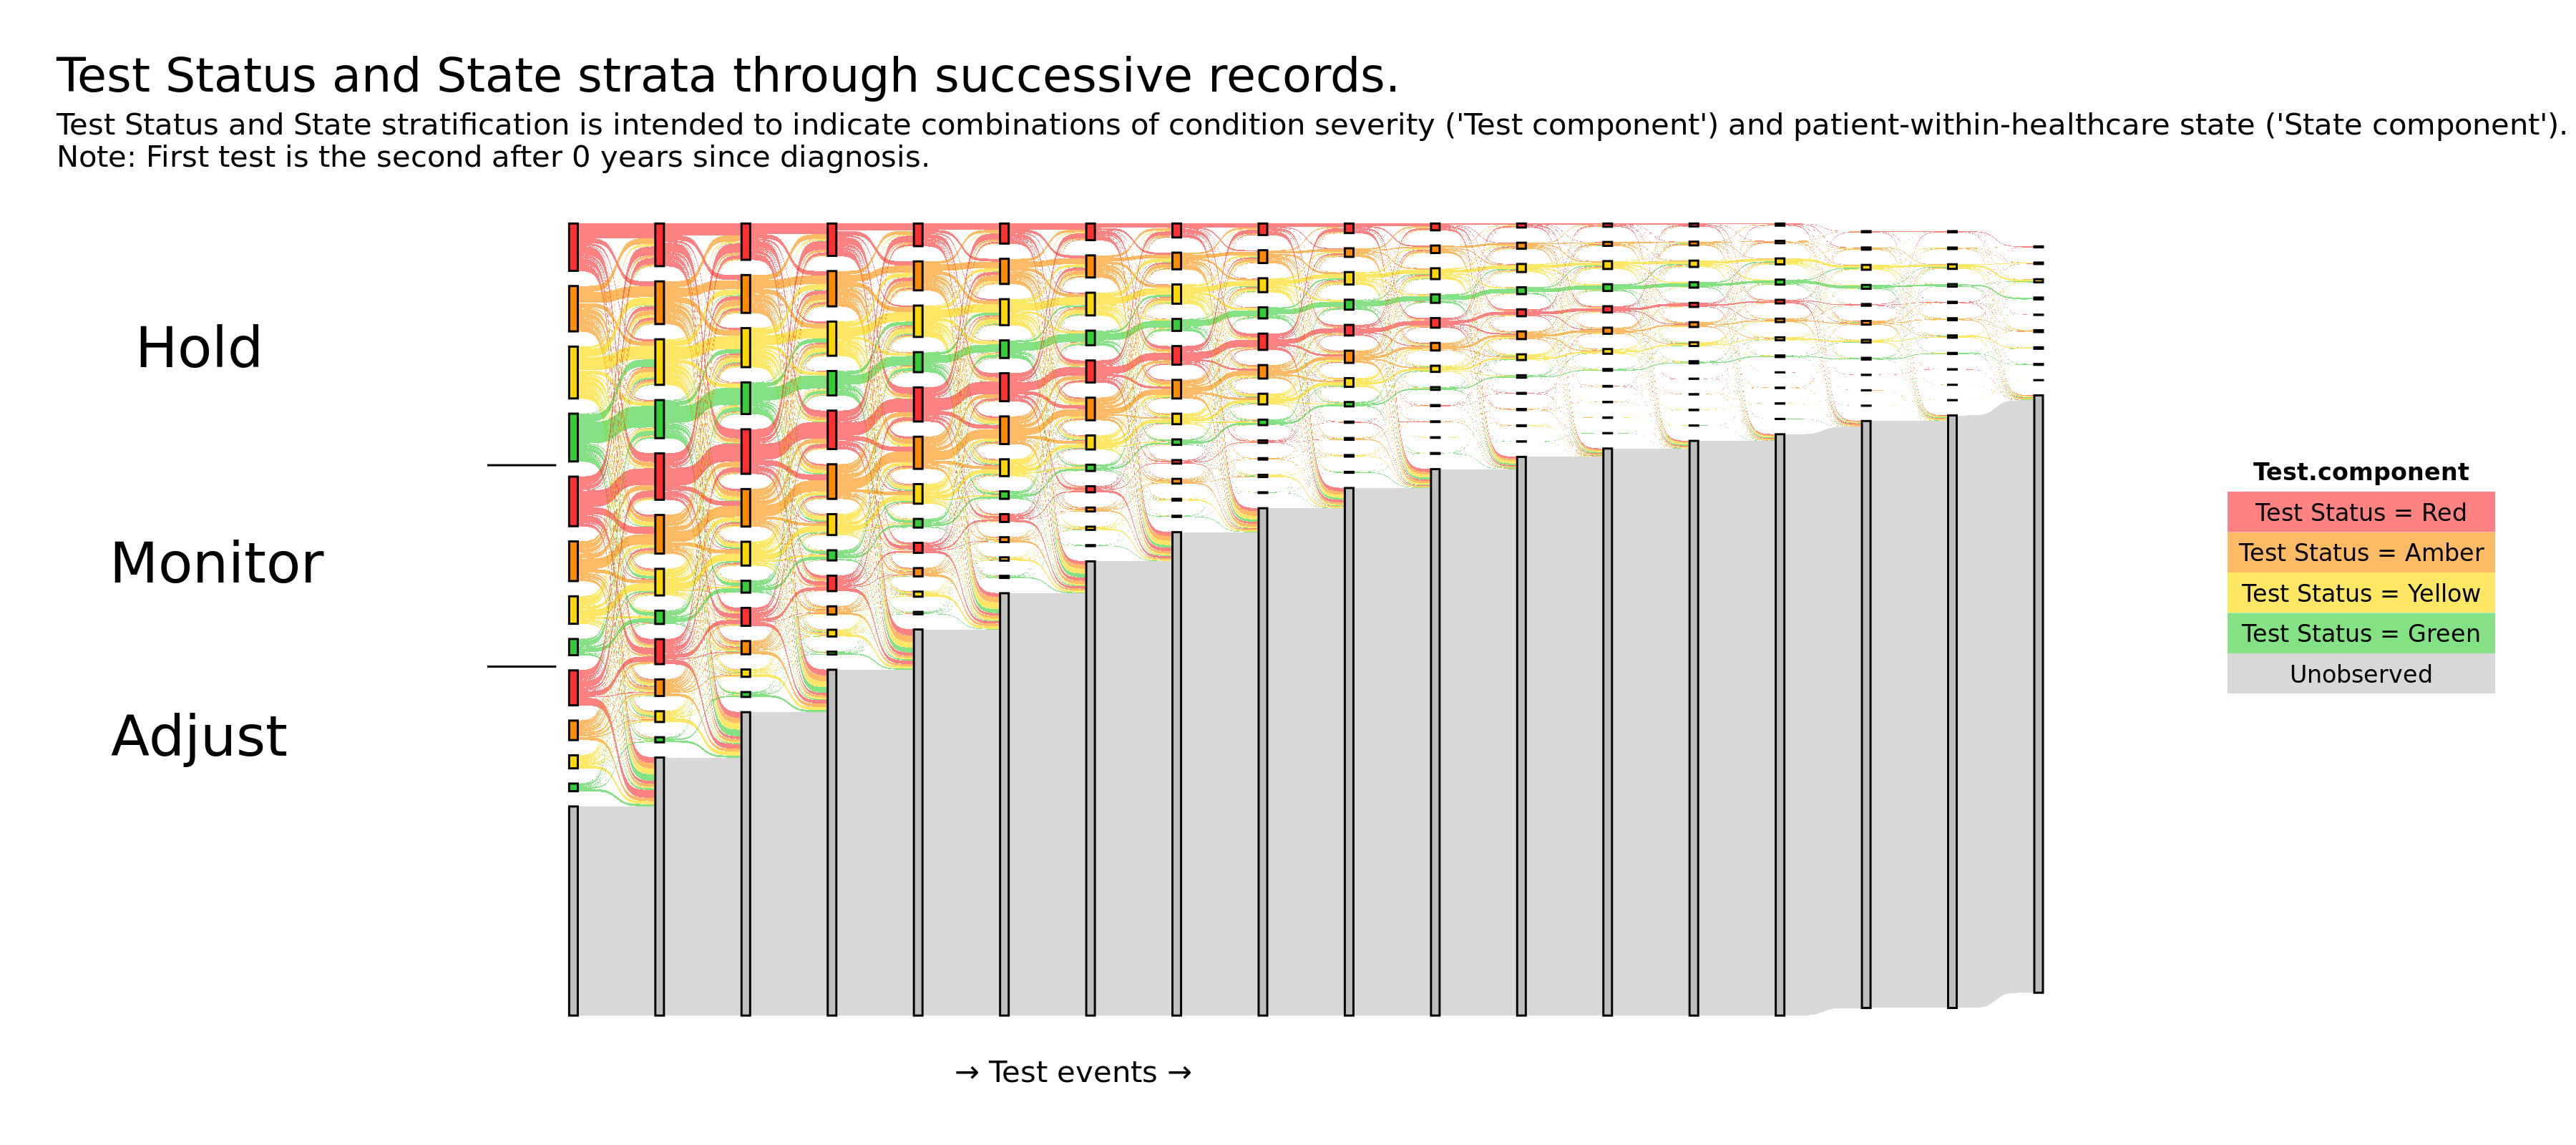

In [48]:
# Make plot data.
plotData <-
    sts_seqmine_HMAandTestStatus %>%
    # Remove the default start node.
    dplyr::select( - last_col(), -a2 ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings()

# Calculate where to place the line segment that divides the H.M.A. categories.
default_space <-
    plotData %>%
    dplyr::mutate( group = 1 ) %>%
    dplyr::select( - next_x, - next_node, - next_x) %>%
    dplyr::group_by_all() %>%
    dplyr::summarise(freq = dplyr::n(), .groups = "keep") %>%
    dplyr::ungroup() %>%
    # The follow is adapted from ggsankey:::find_default_space().
    dplyr::group_by(x) %>%
    dplyr::summarise(n_groups = dplyr::n_distinct(node),
              freq = sum(freq, na.rm = TRUE)) %>%
    dplyr::mutate(v = freq / n_groups / 4) %>%
    dplyr::pull(v) %>%
    max()
n_patients_Hold_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a3, pattern = "Hold" ) ) %>% nrow()
n_patients_Monitor_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a3, pattern = "Monitor" ) ) %>% nrow()
n_patients_Adjust_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a3, pattern = "Adjust" ) ) %>% nrow()
n_patients_Unobserved_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a3, pattern = "Unobserved" ) ) %>% nrow()
y_segment_Adjust <- n_patients_Adjust_at_start + n_patients_Unobserved_at_start + ( 4 * default_space ) 
y_segment_Monitor <- y_segment_Adjust + n_patients_Monitor_at_start + ( 4.5 * default_space ) 
top <- y_segment_Monitor + n_patients_Hold_at_start +  ( 3 * default_space )
y_label_Hold <- y_segment_Monitor + ( ( ( 3 * default_space ) + n_patients_Hold_at_start ) / 2 )
y_label_Monitor <- y_segment_Monitor - ( ( ( 4 * default_space ) + n_patients_Monitor_at_start ) / 2 )
y_label_Adjust <- y_segment_Adjust - ( ( ( 4 * default_space ) + n_patients_Adjust_at_start ) / 2 )
y_segment_Adjust <- y_segment_Adjust - ( top / 2 )
y_segment_Monitor <- y_segment_Monitor - ( top / 2 )
y_label_Hold <- y_label_Hold - ( top / 2 )
y_label_Monitor <- y_label_Monitor - ( top / 2 )
y_label_Adjust <- y_label_Adjust - ( top / 2 )

# Make plot graphic.
plot_sankey <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    # Plot Sankey.
    ggsankey::geom_sankey(
        flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
        ,node.color = 1
        #,space = 33
    ) +
    # Annotate the left side of the plot with labels.
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Monitor, yend = y_segment_Monitor ) +
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Adjust, yend = y_segment_Adjust ) +
    annotate("text", x = -5, label = "\t\tHold", size = 10, y = y_label_Hold ) +
    annotate("text", x = -4.8, label = "\t\tMonitor", size = 10, y = y_label_Monitor ) +
    annotate("text", x = -5, label = "\t\tAdjust", size = 10, y = y_label_Adjust ) +
    # Overlay count labels.
#    ggsankey::geom_sankey_label(
#        aes(
#          x = as.numeric(x) + .05,
#          label = after_stat(paste0(freq))
#        ),
#        size = 8 / .pt, color = "white", fill = "gray40",
#        hjust = 0
#      ) +
    labs(
        title = "Test Status and State strata through successive records."
        ,subtitle =
            paste0(
                "Test Status and State stratification is intended to indicate combinations of condition severity (\'Test component"
                ,"\') and patient-within-healthcare state (\'State component\').\n"
                ,paste0("Note: First test is the second after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual( values = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
    # Finish theme.
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 15 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.position = 'none'
        ,axis.text.y = element_blank()
        ,axis.title.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

# Make table explaining the strata.
plot_table <-
    HMAandTestStatus_display_table %>%
    dplyr::select( Test.component ) %>%
    dplyr::slice_tail( n = 5 ) %>%
    # Basic table layout.
    gridExtra::tableGrob(
        rows = NULL
        ,theme = 
        gridExtra::ttheme_minimal(
            core = list(
                bg_params = list( fill = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::slice_tail( n = 5 ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
            )
        )
    )           

# Plot.
options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

plot_HMAandTestStatus_Sankey_counts <-
    cowplot::plot_grid(
        plot_sankey, plot_table
        ,nrow = 1
        ,rel_widths = c( 5/6, 1/6 )
    )

suppressWarnings( print( plot_HMAandTestStatus_Sankey_counts ) )

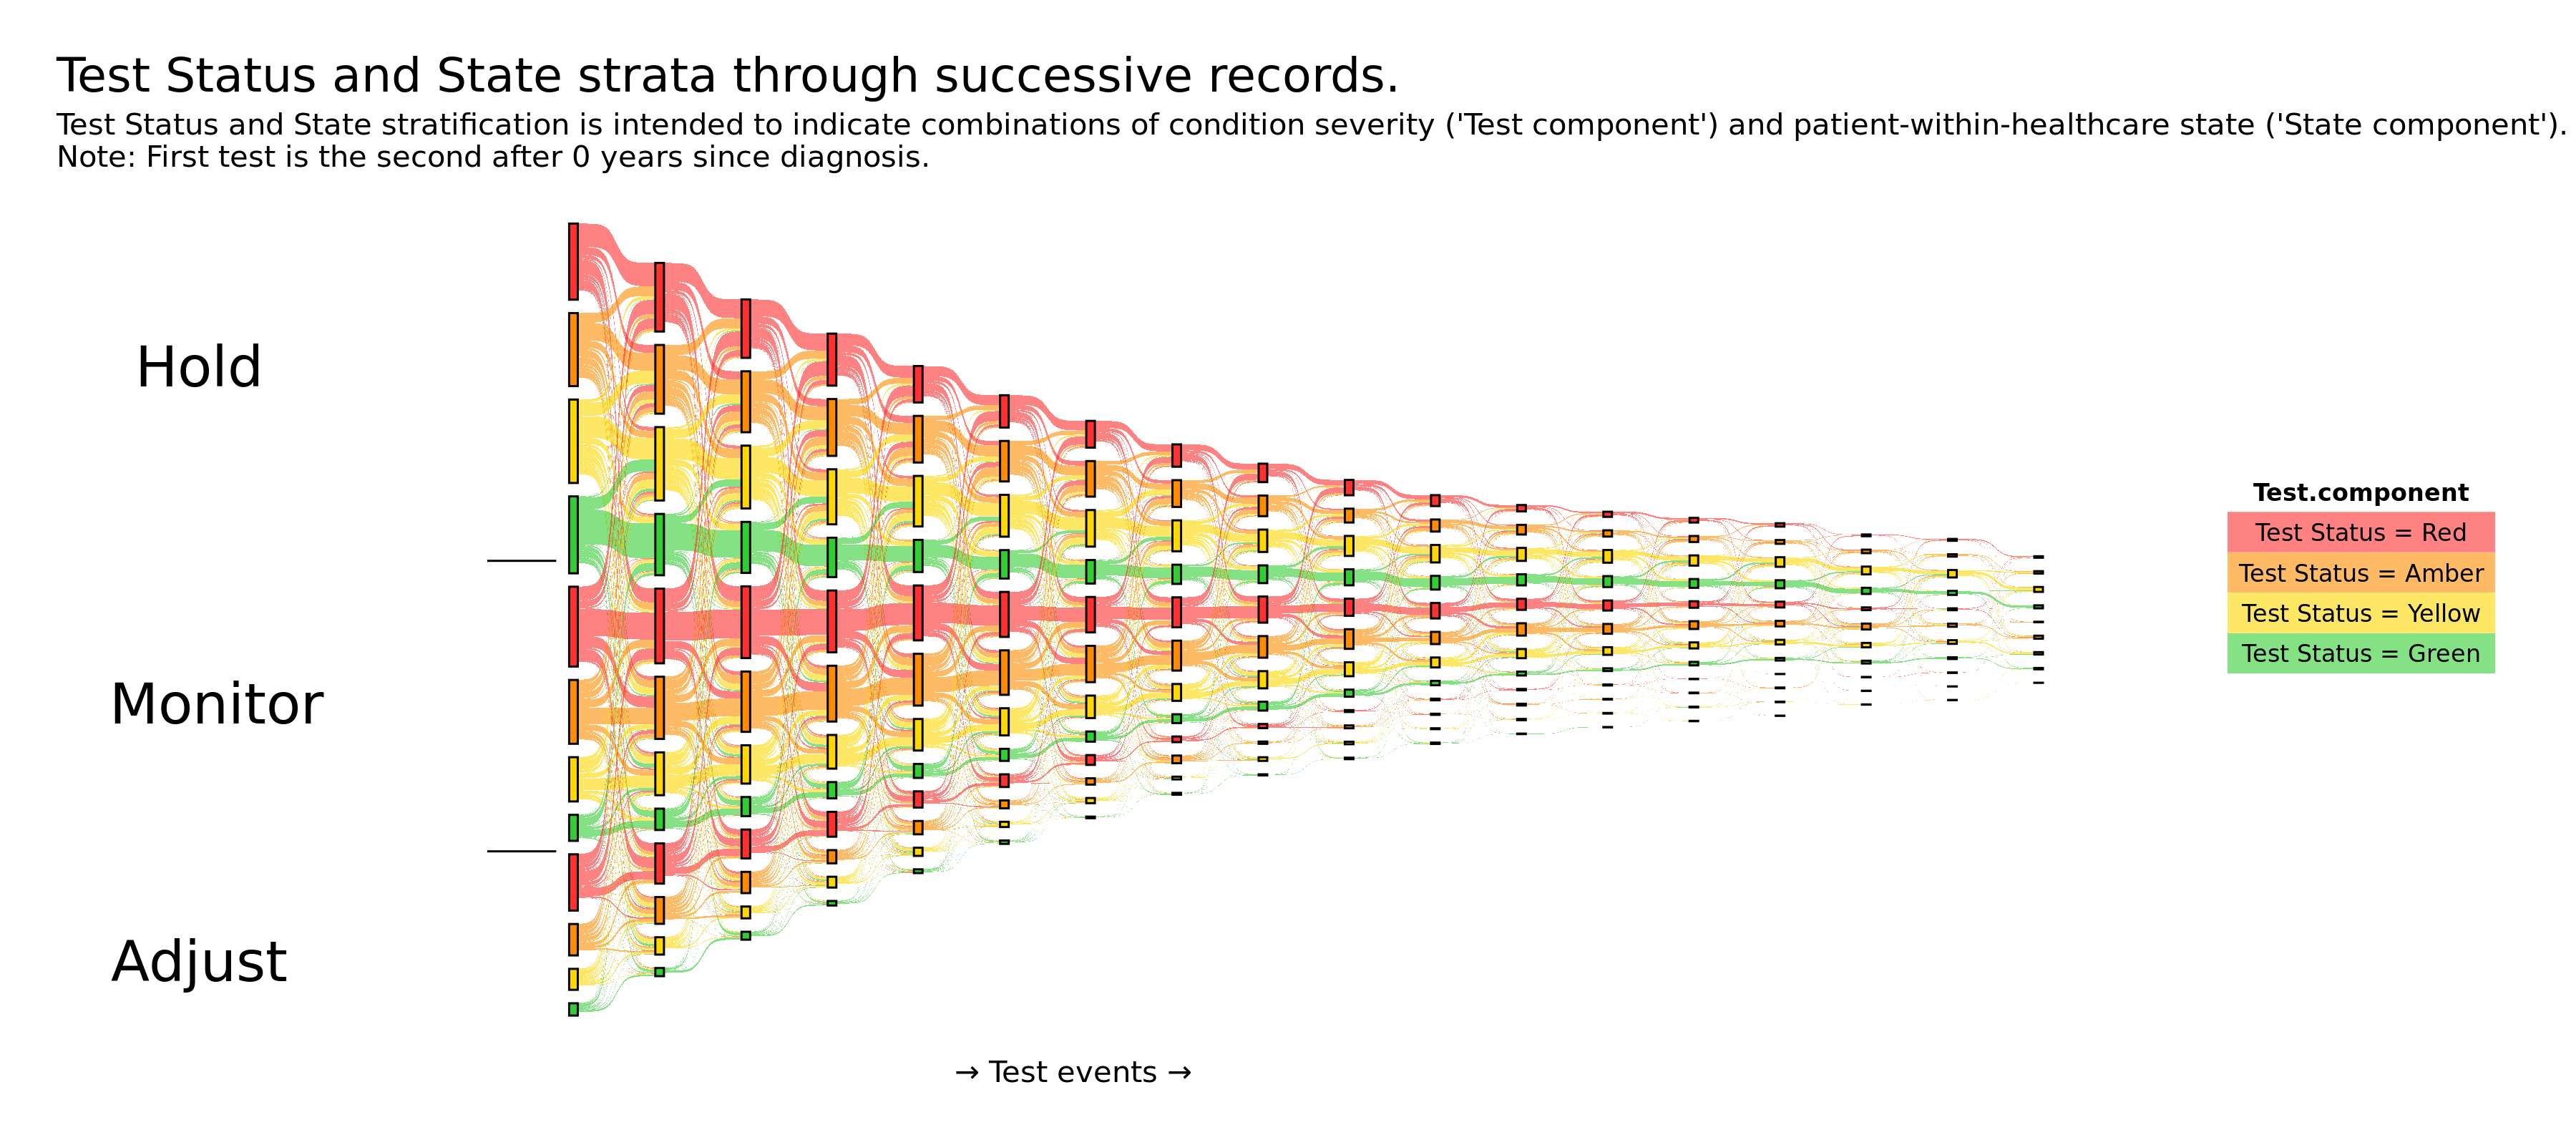

In [49]:
# Make plot data.
plotData <-
    sts_seqmine_HMAandTestStatus %>% #_excludingUnobserved %>%
    # Remove the default start node.
    dplyr::select( - last_col(), -a2 ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings() %>%
    dplyr::mutate(
        node = dplyr::if_else( node == "Unobserved", NA, node )
        ,next_node = dplyr::if_else( next_node == "Unobserved", NA, next_node )
    ) %>%
    dplyr::filter( !is.na( node ) )

# Calculate where to place the line segment that divides the H.M.A. categories.
default_space <-
    plotData %>%
    dplyr::mutate(group = 1) %>%
    dplyr::select(-next_x, -next_node, -next_x) %>%
    dplyr::group_by_all() %>%
    dplyr::summarise(freq = dplyr::n(), .groups = "keep") %>%
    dplyr::ungroup() %>%
    # The follow is adapted from ggsankey:::find_default_space().
    dplyr::group_by(x) %>%
    dplyr::summarise(n_groups = dplyr::n_distinct(node),
              freq = sum(freq, na.rm = TRUE)) %>%
    dplyr::mutate(v = freq / n_groups / 4) %>%
    dplyr::pull(v) %>%
    max()
n_patients_Hold_at_start <- sts_seqmine_HMAandTestStatus_excludingUnobserved %>% dplyr::filter( stringr::str_detect( a3, pattern = "Hold" ) ) %>% nrow()
n_patients_Monitor_at_start <- sts_seqmine_HMAandTestStatus_excludingUnobserved %>% dplyr::filter( stringr::str_detect( a3, pattern = "Monitor" ) ) %>% nrow()
n_patients_Adjust_at_start <- sts_seqmine_HMAandTestStatus_excludingUnobserved %>% dplyr::filter( stringr::str_detect( a3, pattern = "Adjust" ) ) %>% nrow()
n_patients_half <- sum( n_patients_Hold_at_start, n_patients_Monitor_at_start, n_patients_Adjust_at_start ) / 2
y_segment_Adjust <- n_patients_Adjust_at_start + ( 4 * default_space ) 
y_segment_Monitor <- y_segment_Adjust + n_patients_Monitor_at_start + ( 4.5 * default_space ) 
top <- y_segment_Monitor + n_patients_Hold_at_start +  ( 3 * default_space )
y_label_Hold <- y_segment_Monitor + ( ( ( 3 * default_space ) + n_patients_Hold_at_start ) / 2 )
y_label_Monitor <- y_segment_Monitor - ( ( ( 4 * default_space ) + n_patients_Monitor_at_start ) / 2 )
y_label_Adjust <- y_segment_Adjust - ( ( ( 4 * default_space ) + n_patients_Adjust_at_start ) / 2 )
y_segment_Adjust <- y_segment_Adjust - ( top / 2 )
y_segment_Monitor <- y_segment_Monitor - ( top / 2 )
y_label_Hold <- y_label_Hold - ( top / 2 )
y_label_Monitor <- y_label_Monitor - ( top / 2 )
y_label_Adjust <- y_label_Adjust - ( top / 2 )

# Make plot graphic.
plot_sankey <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    # Plot Sankey.
    ggsankey::geom_sankey(
        flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
        ,node.color = 1
        #,space = 33
    ) +
    # Annotate the left side of the plot with labels.
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Monitor, yend = y_segment_Monitor ) +
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Adjust, yend = y_segment_Adjust ) +
    annotate("text", x = -5, label = "\t\tHold", size = 10, y = y_label_Hold ) +
    annotate("text", x = -4.8, label = "\t\tMonitor", size = 10, y = y_label_Monitor ) +
    annotate("text", x = -5, label = "\t\tAdjust", size = 10, y = y_label_Adjust ) +
    labs(
        title = "Test Status and State strata through successive records."
        ,subtitle =
            paste0(
                "Test Status and State stratification is intended to indicate combinations of condition severity (\'Test component"
                ,"\') and patient-within-healthcare state (\'State component\').\n"
               ,paste0("Note: First test is the second after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual( values = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
    scale_y_continuous( breaks = seq(-5000,5000,500) ) +
    # Finish theme.
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 15 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.position = 'none'
        ,axis.text.y = element_blank()
        ,axis.title.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

# Make table explaining the strata.
plot_table_excludingUnobserved <-
    HMAandTestStatus_display_table %>%
    dplyr::filter( Test.component != "Unobserved" ) %>%
    dplyr::select( Test.component ) %>%
    dplyr::slice_head( n = 4 ) %>%
    # Basic table layout.
    gridExtra::tableGrob(
        rows = NULL
        ,theme = 
        gridExtra::ttheme_minimal(
            core = list(
                bg_params = list( fill = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::slice_head( n = 4 ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
            )
        )
    )           

# Plot.
options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

plot_HMAandTestStatus_Sankey_excludingUnobserved <-
    cowplot::plot_grid(
        plot_sankey, plot_table_excludingUnobserved
        ,nrow = 1
        ,rel_widths = c( 5/6, 1/6 )
    )

suppressWarnings( print( plot_HMAandTestStatus_Sankey_excludingUnobserved ) )

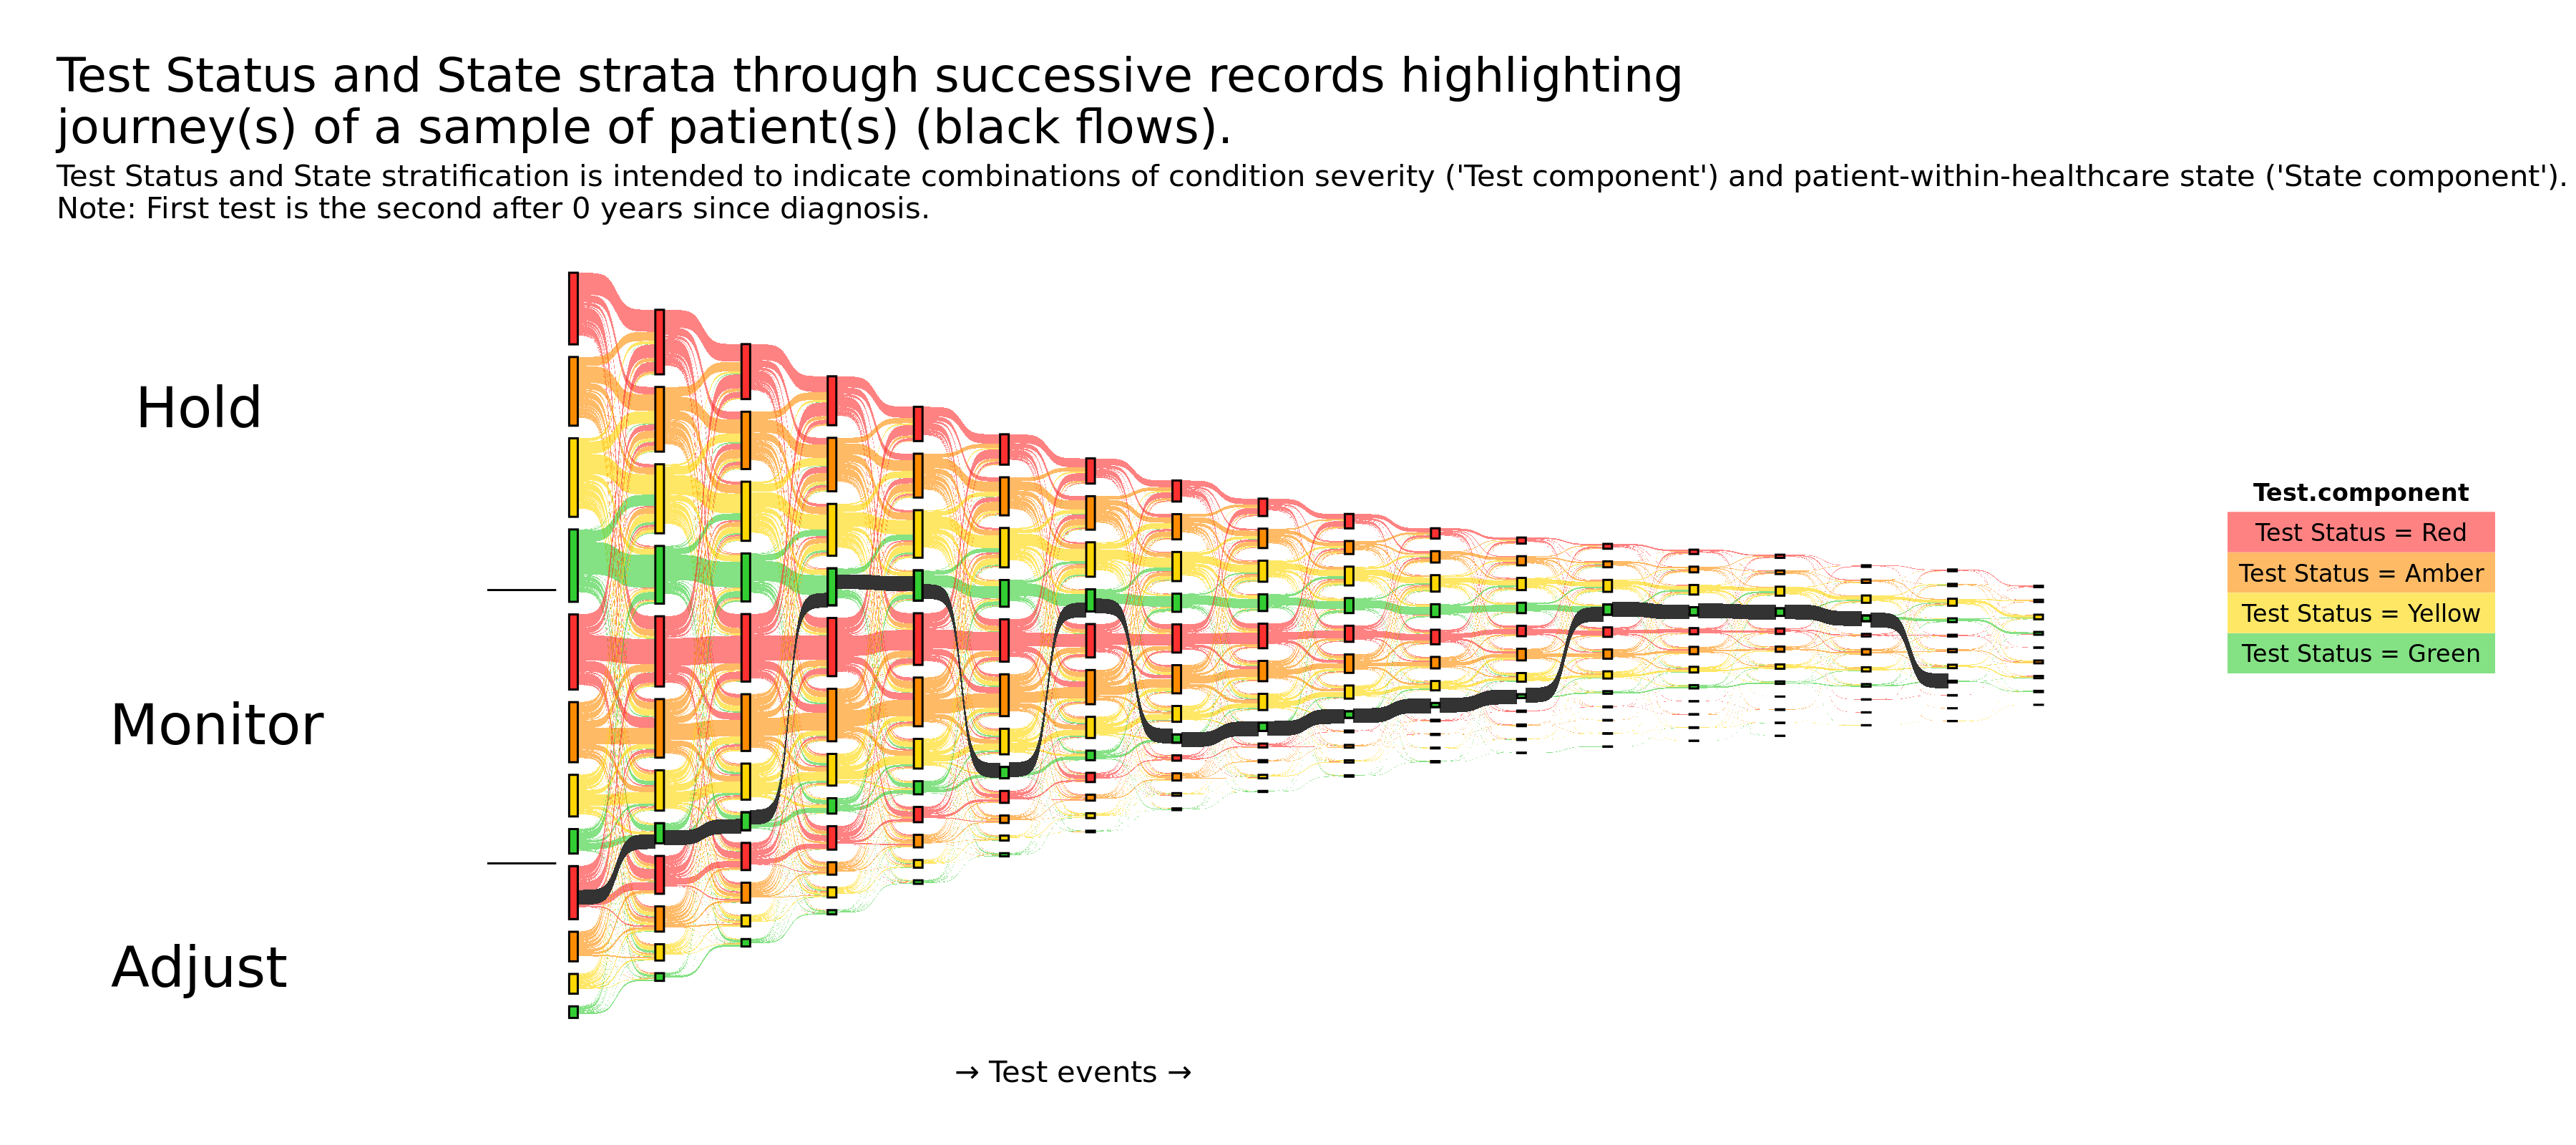

In [52]:
# Set plot parameters.
n_records_to_sample <- 1

# Make plot data.
plotData <-
    sts_seqmine_HMAandTestStatus %>%
    # Remove the default start node.
    dplyr::select( - last_col(), -a2 ) %>%
    ggsankey::make_long( colnames( . ), subset.logic = "random", n.random = n_records_to_sample ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings() %>%
    dplyr::mutate(
        node = dplyr::if_else( node == "Unobserved", NA, node )
        ,next_node = dplyr::if_else( next_node == "Unobserved", NA, next_node )
    ) %>%
    dplyr::filter( !is.na( node ) )

# Calculate where to place the line segment that divides the H.M.A. categories.
default_space <-
    plotData %>%
    dplyr::mutate(group = 1) %>%
    dplyr::select(-next_x, -next_node, -next_x) %>%
    dplyr::group_by_all() %>%
    dplyr::summarise(freq = dplyr::n(), .groups = "keep") %>%
    dplyr::ungroup() %>%
    # The follow is adapted from ggsankey:::find_default_space().
    dplyr::group_by(x) %>%
    dplyr::summarise(n_groups = dplyr::n_distinct(node),
              freq = sum(freq, na.rm = TRUE)) %>%
    dplyr::mutate(v = freq / n_groups / 4) %>%
    dplyr::pull(v) %>%
    max()
n_patients_Hold_at_start <- sts_seqmine_HMAandTestStatus_excludingUnobserved %>% dplyr::filter( stringr::str_detect( a3, pattern = "Hold" ) ) %>% nrow()
n_patients_Monitor_at_start <- sts_seqmine_HMAandTestStatus_excludingUnobserved %>% dplyr::filter( stringr::str_detect( a3, pattern = "Monitor" ) ) %>% nrow()
n_patients_Adjust_at_start <- sts_seqmine_HMAandTestStatus_excludingUnobserved %>% dplyr::filter( stringr::str_detect( a3, pattern = "Adjust" ) ) %>% nrow()
n_patients_half <- sum( n_patients_Hold_at_start, n_patients_Monitor_at_start, n_patients_Adjust_at_start ) / 2
y_segment_Adjust <- n_patients_Adjust_at_start + ( 4 * default_space ) 
y_segment_Monitor <- y_segment_Adjust + n_patients_Monitor_at_start + ( 4.5 * default_space ) 
top <- y_segment_Monitor + n_patients_Hold_at_start +  ( 3 * default_space )
y_label_Hold <- y_segment_Monitor + ( ( ( 3 * default_space ) + n_patients_Hold_at_start ) / 2 )
y_label_Monitor <- y_segment_Monitor - ( ( ( 4 * default_space ) + n_patients_Monitor_at_start ) / 2 )
y_label_Adjust <- y_segment_Adjust - ( ( ( 4 * default_space ) + n_patients_Adjust_at_start ) / 2 )
y_segment_Adjust <- y_segment_Adjust - ( top / 2 )
y_segment_Monitor <- y_segment_Monitor - ( top / 2 )
y_label_Hold <- y_label_Hold - ( top / 2 )
y_label_Monitor <- y_label_Monitor - ( top / 2 )
y_label_Adjust <- y_label_Adjust - ( top / 2 )

# Make plot graphic.
plot_sankey <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    # Plot Sankey.
    ggsankey::geom_sankey(
        flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
        ,node.color = 1
        #,space = 33
    ) +
    ggsankey::geom_sankey_subset( mapping = ggplot2::aes( subset.idx = subset.idx ), range.scalar = 1 ) +
    # Annotate the left side of the plot with labels.
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Monitor, yend = y_segment_Monitor ) +
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Adjust, yend = y_segment_Adjust ) +
    annotate("text", x = -5, label = "\t\tHold", size = 10, y = y_label_Hold ) +
    annotate("text", x = -4.8, label = "\t\tMonitor", size = 10, y = y_label_Monitor ) +
    annotate("text", x = -5, label = "\t\tAdjust", size = 10, y = y_label_Adjust ) +
    labs(
        title = "Test Status and State strata through successive records highlighting\njourney(s) of a sample of patient(s) (black flows)."
        ,subtitle =
            paste0(
                "Test Status and State stratification is intended to indicate combinations of condition severity (\'Test component"
                ,"\') and patient-within-healthcare state (\'State component\').\n"
               ,paste0("Note: First test is the second after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual( values = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
    scale_y_continuous( breaks = seq(-5000,5000,500) ) +
    # Finish theme.
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 15 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.position = 'none'
        ,axis.text.y = element_blank()
        ,axis.title.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

# Make table explaining the strata.
plot_table_excludingUnobserved <-
    HMAandTestStatus_display_table %>%
    dplyr::filter( Test.component != "Unobserved" ) %>%
    dplyr::select( Test.component ) %>%
    dplyr::slice_head( n = 4 ) %>%
    # Basic table layout.
    gridExtra::tableGrob(
        rows = NULL
        ,theme = 
        gridExtra::ttheme_minimal(
            core = list(
                bg_params = list( fill = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::slice_head( n = 4 ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
            )
        )
    )           

# Plot.
options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

plot_HMAandTestStatus_Sankey_excludingUnobserved <-
    cowplot::plot_grid(
        plot_sankey, plot_table_excludingUnobserved
        ,nrow = 1
        ,rel_widths = c( 5/6, 1/6 )
    )

suppressWarnings( print( plot_HMAandTestStatus_Sankey_excludingUnobserved ) )

Some observations from the Test Status-and-State Sankey diagrams:

1. __All test statuses are observed in all states, throughout the observation window.__
    - Evidenced by flows of all colours in all inter-test intervals.
<br></br>

2. __There are fewer health records with longer sequences of test events.__
    - Evidenced by the narrowing of the unscaled proportions plots, and by the increase in 'Unobserved' state in the count plot.
<br></br>

3. __As sequence length increases, healthcare records are more likely to have Red test statuses in the 'Adjust' state, Red or Amber in the 'Monitor' state, and Yellow (though more evenly balanced) in the 'Hold' state.__
     - Evidenced by the change in relative heights of the vertical bars from left to right, in the rescaled proportions plot.
<br></br>

# Quantifying the complexity of test status sequences

We quantified the complexity of patients’ test statuses when in each of the “Hold”, “Monitor”, and “Adjust” states using [(Gabadinho et al. 2010](https://www.researchgate.net/profile/Gilbert-Ritschard/publication/220786242_Indice_de_complexite_pour_le_tri_et_la_comparaison_de_sequences_categorielles/links/53edabdb0cf26b9b7dc5f259/Indice-de-complexite-pour-le-tri-et-la-comparaison-de-sequences-categorielles.pdf)) complexity index. The __Complexity Index__ statistic is the geometric mean of a scaled count of transitions in a sequence and the sequence's scaled longitudinal entropy. The count of transitions is scaled to the length of the sequence, and the longitundinal entropy is scaled to the theoretical maximum of $log_{a}$, where $a$ is the count of unique states across all sequences, even those not observed in the sequence (i.e. its alphabet).

For our simple situation, a = 5 because the test status can only be red, amber, yellow, or green, and an ‘Unobserved’ placeholder that we used once a patient’s journey had ended. It's range is between 0 and 1., with 1 indicate maximum complexity, i.e. changes through the entire range of values at every possible opportunity.

First, I plot the distribution of sequence complexity indices irrespective of changes in state.

## Overall sequence complexity of test statuses, irrespective of changes in state

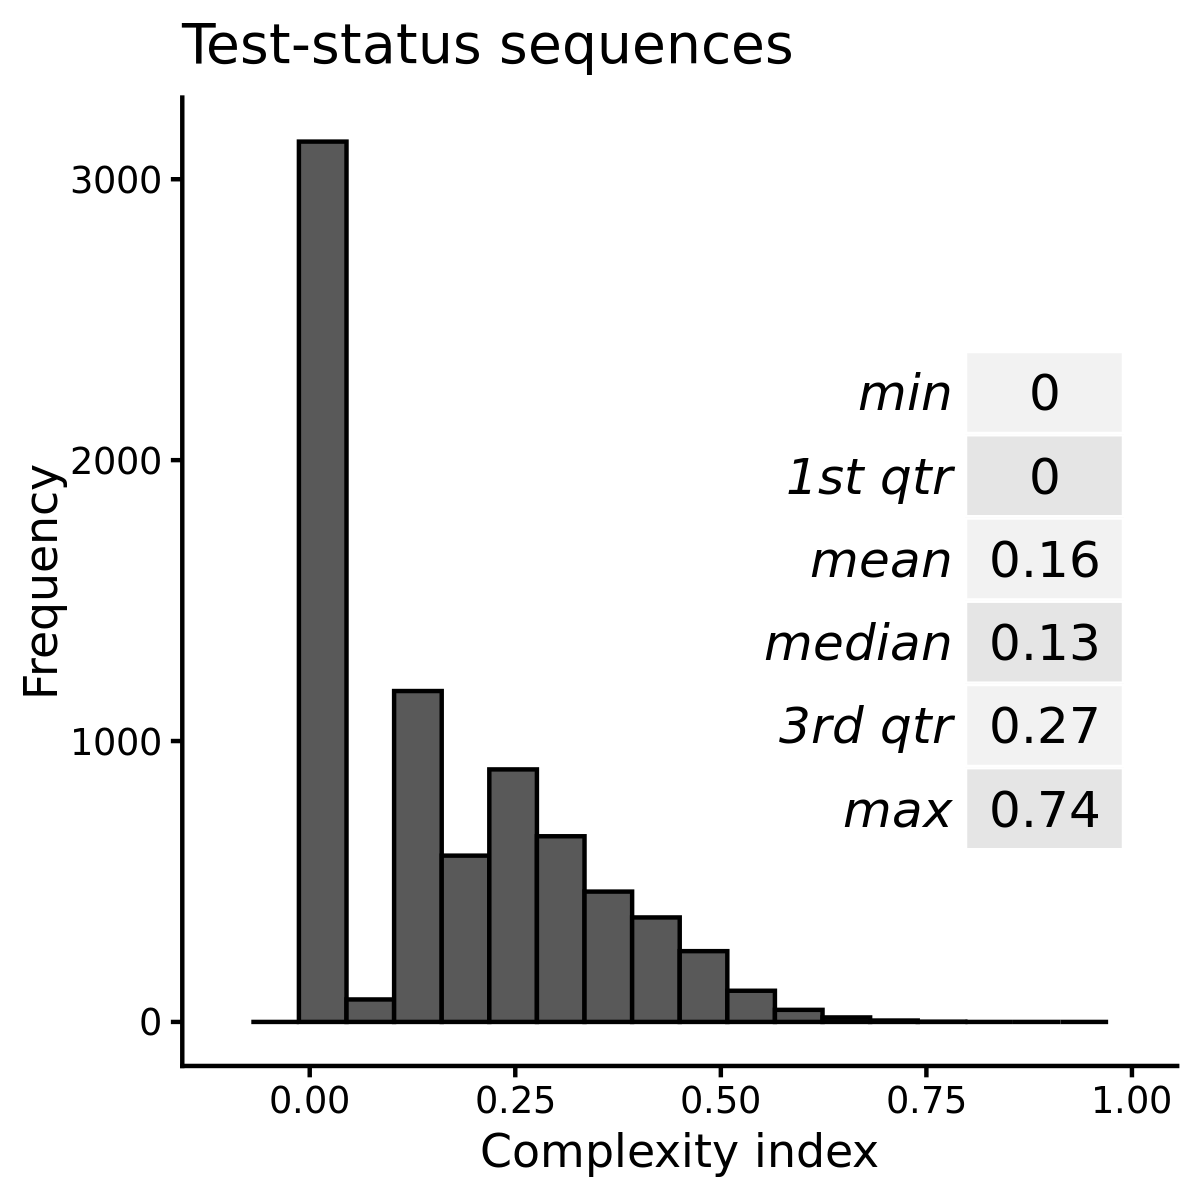

In [22]:
# Calculate statistics over all patient records.
sts_seqmine_test_only[sts_seqmine_test_only == "Unobserved"] <- NA # Here, I removed the 'Unobserved' placeholder.
seq_complexity_test_only <- TraMineR::seqici( sts_seqmine_test_only )

# Create table of summary statistics.
plot_table <-
   seq_complexity_test_only %>%
    as.data.frame() %>%
    dplyr::summarise(
        min = min( C )
        ,`1st qtr` = quantile( C, 0.25 )
        ,mean = mean( C )
        ,median = median( C )
        ,`3rd qtr` = quantile( C, 0.75 )
        ,max = max( C )
    ) %>%
    base::round(2) %>%
    t()

# Plot histograms and summary statistics.
options( repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300 )
n_bins <- 20
plot_sequenceComplexity_test_only <-
    seq_complexity_test_only %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( C ), bins = n_bins, colour = "black", position = "dodge" ) +
    labs( title = "Test-status sequences", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    annotation_custom( tableGrob( plot_table ), xmin = 0.5, xmax = 1, ymin = 500, ymax = 2500 ) +
    theme_classic()

suppressWarnings( print( plot_sequenceComplexity_test_only ) )

The plot above shows:
- Patient records are more likely to be of lower complexity.
- There is an approximate exponential decay of increasing complexity in fewer and fewer patient records.
- The larger complexity-index values indicate that some patient records show frequent changes through wide range of test statuses.

This plot should be considered as context for the complexity of sequences of test status in the population of health records. Next, I stratify the sequences into subsequences of “Hold”, “Monitor”, and “Adjust” states. A healthcare  record's subsequence is defined by consecutive test events within a state. For example, a pattern of `'Hold'|Green -> 'Hold'|Yellow -> 'Monitor'|Yellow -> 'Hold'|Yellow` contains three subsequences. The first subsequence is `Green -> Yellow` in an 'Hold' state; the second subsequence is `Yellow` in a 'Monitor' state; the third subsequence is `Yellow` in an 'Hold' state. The first state has minimal complexity and the latter two have zero complexity.

Note that the previous plot shows complexity-index values for patients' entire healthcare records, while the following calculations will provide a complexity-index value for each _subsequence_ found in patients' healthcare records.

## State-specific subsequence complexity of test statuses

In [23]:
# Define list of events to focus on.
events_selection <-
    df_event_factor %>%
    dplyr::select( event_fct_order ) %>%
    dplyr::filter( stringr::str_detect( event_fct_order, pattern = "(Test)" ) | event_fct_order == "Unobserved" ) %>%
    droplevels() %>%
    dplyr::pull()

# Cut/Stratify/Split time series object by state (within patient).
df_seq_test_only_stratified_by_state <-
    df_seq_test_only %>%
    dplyr::select( person_id, HMA, event_value, rn ) %>%
    base::split( .$HMA)

# Convert the time series objects to state sequence objects.
# ## Hold
person_subsequences_Hold <- 
    df_seq_test_only_stratified_by_state$Hold %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate(
        diff = rn - lag( rn, default = first( rn ) )
        ,is_new_group = diff != 1
        ,pseq_increment = cumsum( is_new_group )
        ,pseq_id = paste0( person_id, "_", pseq_increment )
    ) %>%
    dplyr::ungroup() %>%
    dplyr::group_by( person_id, pseq_increment ) %>%
    dplyr::mutate( pseq_rn = row_number() ) %>%
    as.data.frame() %>%
    dplyr::select( - c( person_id, diff, is_new_group ) )
d_Hold <- 
     TraMineRextras::TSE_to_STS(
                person_subsequences_Hold
                ,id = "pseq_id"
                ,timestamp = "pseq_rn"
                ,event = "event_value"
                ,stm = stm_test_only
                ,tmax = person_subsequences_Hold %>% dplyr::select( pseq_increment ) %>% dplyr::ungroup() %>% max()
                ) %>%
                dplyr::select( - a1 )
statl <- TraMineR:::seqxtract( d_Hold, NULL, data.frame = TRUE ) %>% seqstatl()
sts_seqmine_test_only_Hold <-
    d_Hold %>%
    TraMineR::seqdef( labels = statl) %>%#events_selection[ events_selection %in% statl ] ) %>%
    suppressMessages()
rm( d_Hold )

# ## Monitor
person_subsequences_Monitor <- 
    df_seq_test_only_stratified_by_state$Monitor %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate(
        diff = rn - lag( rn, default = first( rn ) )
        ,is_new_group = diff != 1
        ,pseq_increment = cumsum( is_new_group )
        ,pseq_id = paste0( person_id, "_", pseq_increment )
    ) %>%
    dplyr::ungroup() %>%
    dplyr::group_by( person_id, pseq_increment ) %>%
    dplyr::mutate( pseq_rn = row_number() ) %>%
    as.data.frame() %>%
    dplyr::select( - c( person_id, diff, is_new_group ) )
d_Monitor <- 
     TraMineRextras::TSE_to_STS(
                person_subsequences_Monitor
                ,id = "pseq_id"
                ,timestamp = "pseq_rn"
                ,event = "event_value"
                ,stm = stm_test_only
                ,tmax = person_subsequences_Monitor %>% dplyr::select( pseq_increment ) %>% dplyr::ungroup() %>% max()
                ) %>%
                dplyr::select( - a1 )
statl <- TraMineR:::seqxtract( d_Monitor, NULL, data.frame = TRUE ) %>% seqstatl()
sts_seqmine_test_only_Monitor <-
    d_Monitor %>%
    TraMineR::seqdef( labels = statl) %>%#events_selection[ events_selection %in% statl ] ) %>%
    suppressMessages()
rm( d_Monitor )

# ## Adjust
person_subsequences_Adjust <- 
    df_seq_test_only_stratified_by_state$Adjust %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate(
        diff = rn - lag( rn, default = first( rn ) )
        ,is_new_group = diff != 1
        ,pseq_increment = cumsum( is_new_group )
        ,pseq_id = paste0( person_id, "_", pseq_increment )
    ) %>%
    dplyr::ungroup() %>%
    dplyr::group_by( person_id, pseq_increment ) %>%
    dplyr::mutate( pseq_rn = row_number() ) %>%
    as.data.frame() %>%
    dplyr::select( - c( person_id, diff, is_new_group ) )
d_Adjust <- 
     TraMineRextras::TSE_to_STS(
                person_subsequences_Adjust
                ,id = "pseq_id"
                ,timestamp = "pseq_rn"
                ,event = "event_value"
                ,stm = stm_test_only
                ,tmax = person_subsequences_Adjust %>% dplyr::select( pseq_increment ) %>% dplyr::ungroup() %>% max()
                ) %>%
                dplyr::select( - a1 )
statl <- TraMineR:::seqxtract( d_Adjust, NULL, data.frame = TRUE ) %>% seqstatl()
sts_seqmine_test_only_Adjust <-
    d_Adjust %>%
    TraMineR::seqdef( labels = statl) %>%#events_selection[ events_selection %in% statl ] ) %>%
    suppressMessages()
rm( d_Adjust, statl )

In [24]:
# Calculate statistics over all patient records.
seq_complexity_test_only_Hold <- TraMineR::seqici( sts_seqmine_test_only_Hold )

# Plot histograms and summary statistics.
n_bins <- 20
plot_sequenceComplexity_test_only_Hold <-
    seq_complexity_test_only_Hold %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( C ), bins = n_bins, colour = "black", position = "dodge" ) +
    labs( title = "Hold", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()

In [25]:
# Calculate statistics over all patient records.
seq_complexity_test_only_Monitor <- TraMineR::seqici( sts_seqmine_test_only_Monitor )

# Plot histograms and summary statistics.
n_bins <- 20
plot_sequenceComplexity_test_only_Monitor <-
    seq_complexity_test_only_Monitor %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( C ), bins = n_bins, colour = "black", position = "dodge" ) +
    labs( title = "Monitor", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()

In [26]:
# Calculate statistics over all patient records.
seq_complexity_test_only_Adjust <- TraMineR::seqici( sts_seqmine_test_only_Adjust )

# Plot histograms and summary statistics.
n_bins <- 20
plot_sequenceComplexity_test_only_Adjust <-
    seq_complexity_test_only_Adjust %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( C ), bins = n_bins, colour = "black", position = "dodge" ) +
    labs( title = "Adjust", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


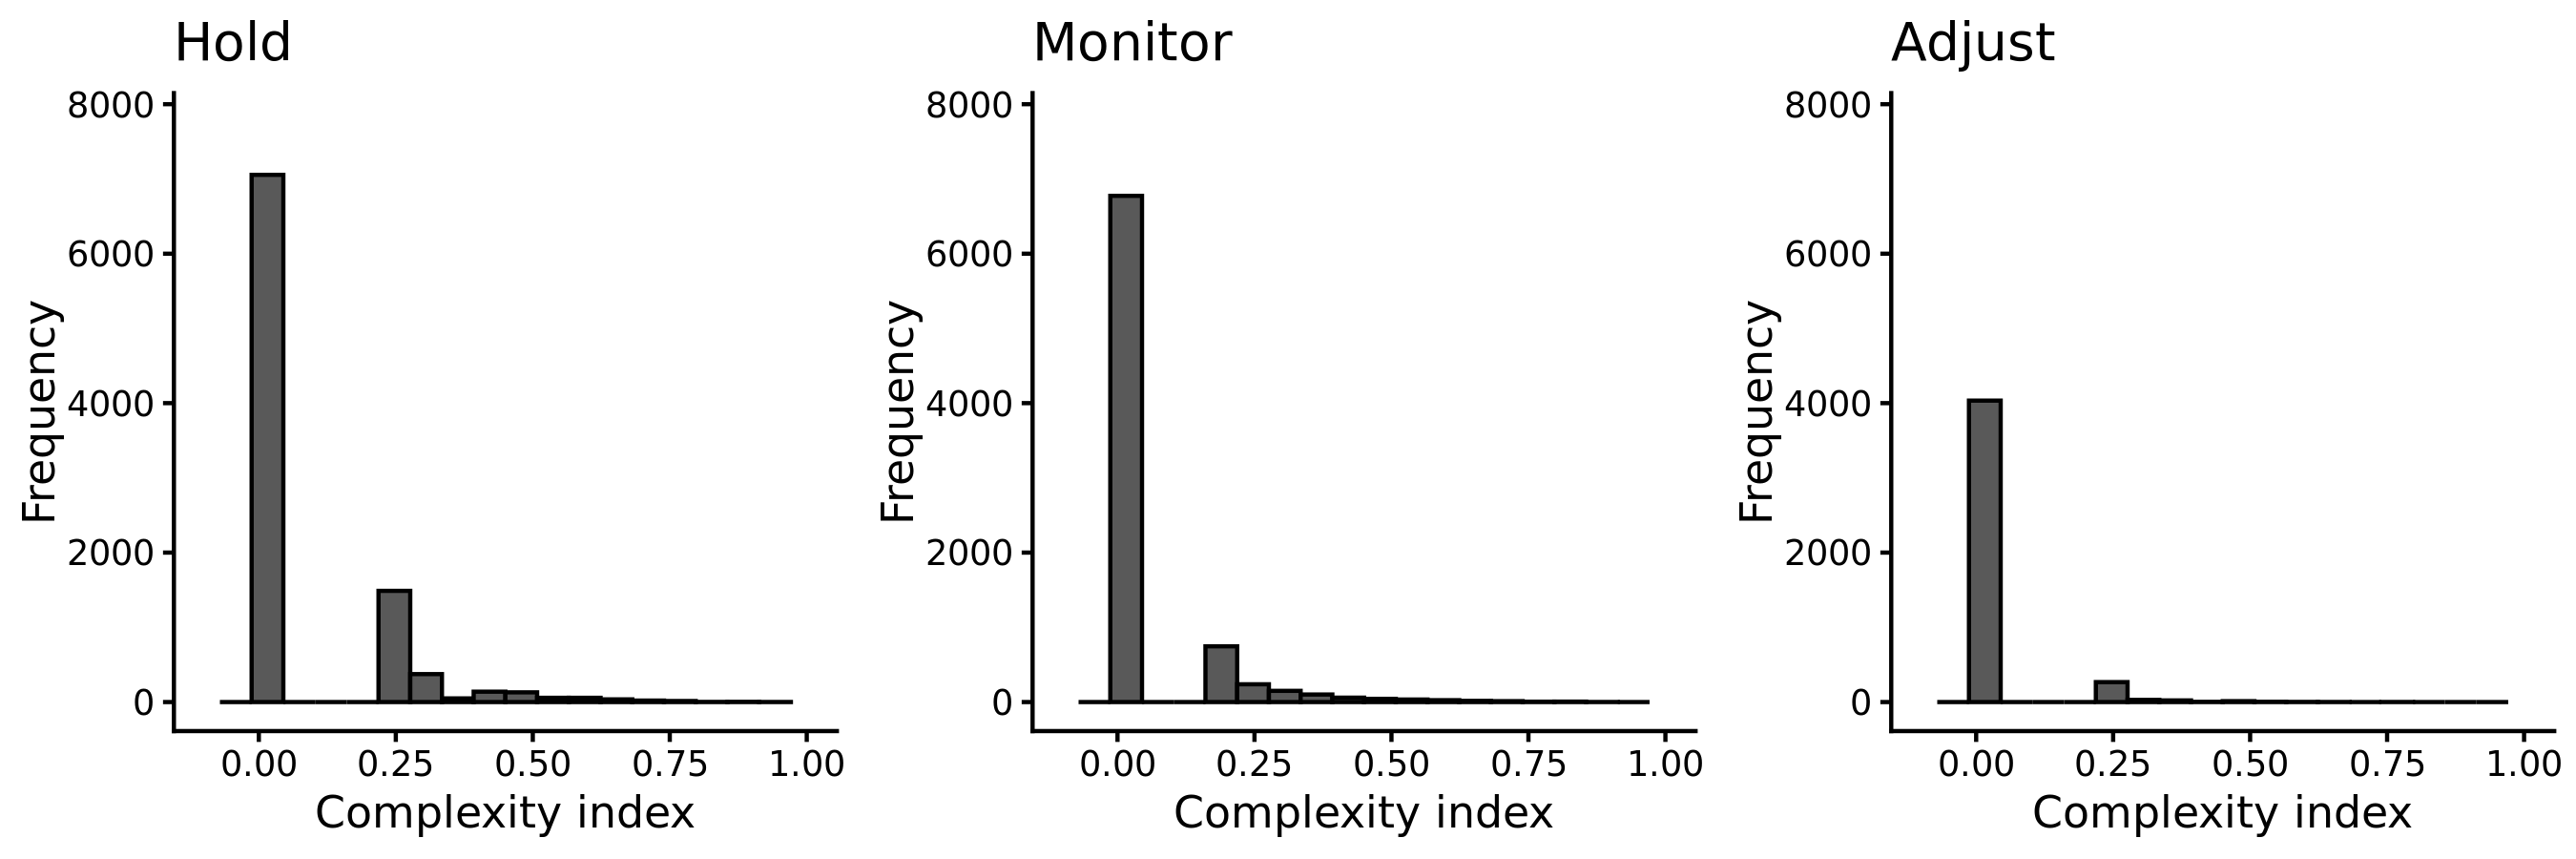

In [27]:
y_top_value <-
    dplyr::bind_rows(
        ggplot2::layer_data( plot_sequenceComplexity_test_only_Hold ) %>% dplyr::summarise( max = max( count ) )
        ,ggplot2::layer_data( plot_sequenceComplexity_test_only_Monitor ) %>% dplyr::summarise( max = max( count ) )
        ,ggplot2::layer_data( plot_sequenceComplexity_test_only_Adjust ) %>% dplyr::summarise( max = max( count ) )
    ) %>%
    dplyr::summarise( max = max( max ) ) %>%
    `*`( 1.1 )%>%
    dplyr::pull()

# Plot histograms.
options( repr.plot.width = 9, repr.plot.height = 3, repr.plot.res = 300 )
plot_sequenceComplexity_test_only_excludingUnobserved_stratified <- 
    cowplot::plot_grid(
        plot_sequenceComplexity_test_only_Hold + ylim( 0, y_top_value )
        ,plot_sequenceComplexity_test_only_Monitor + ylim( 0, y_top_value )
        ,plot_sequenceComplexity_test_only_Adjust + ylim( 0, y_top_value )
        ,nrow = 1
    )

suppressWarnings( print( plot_sequenceComplexity_test_only_excludingUnobserved_stratified ) )

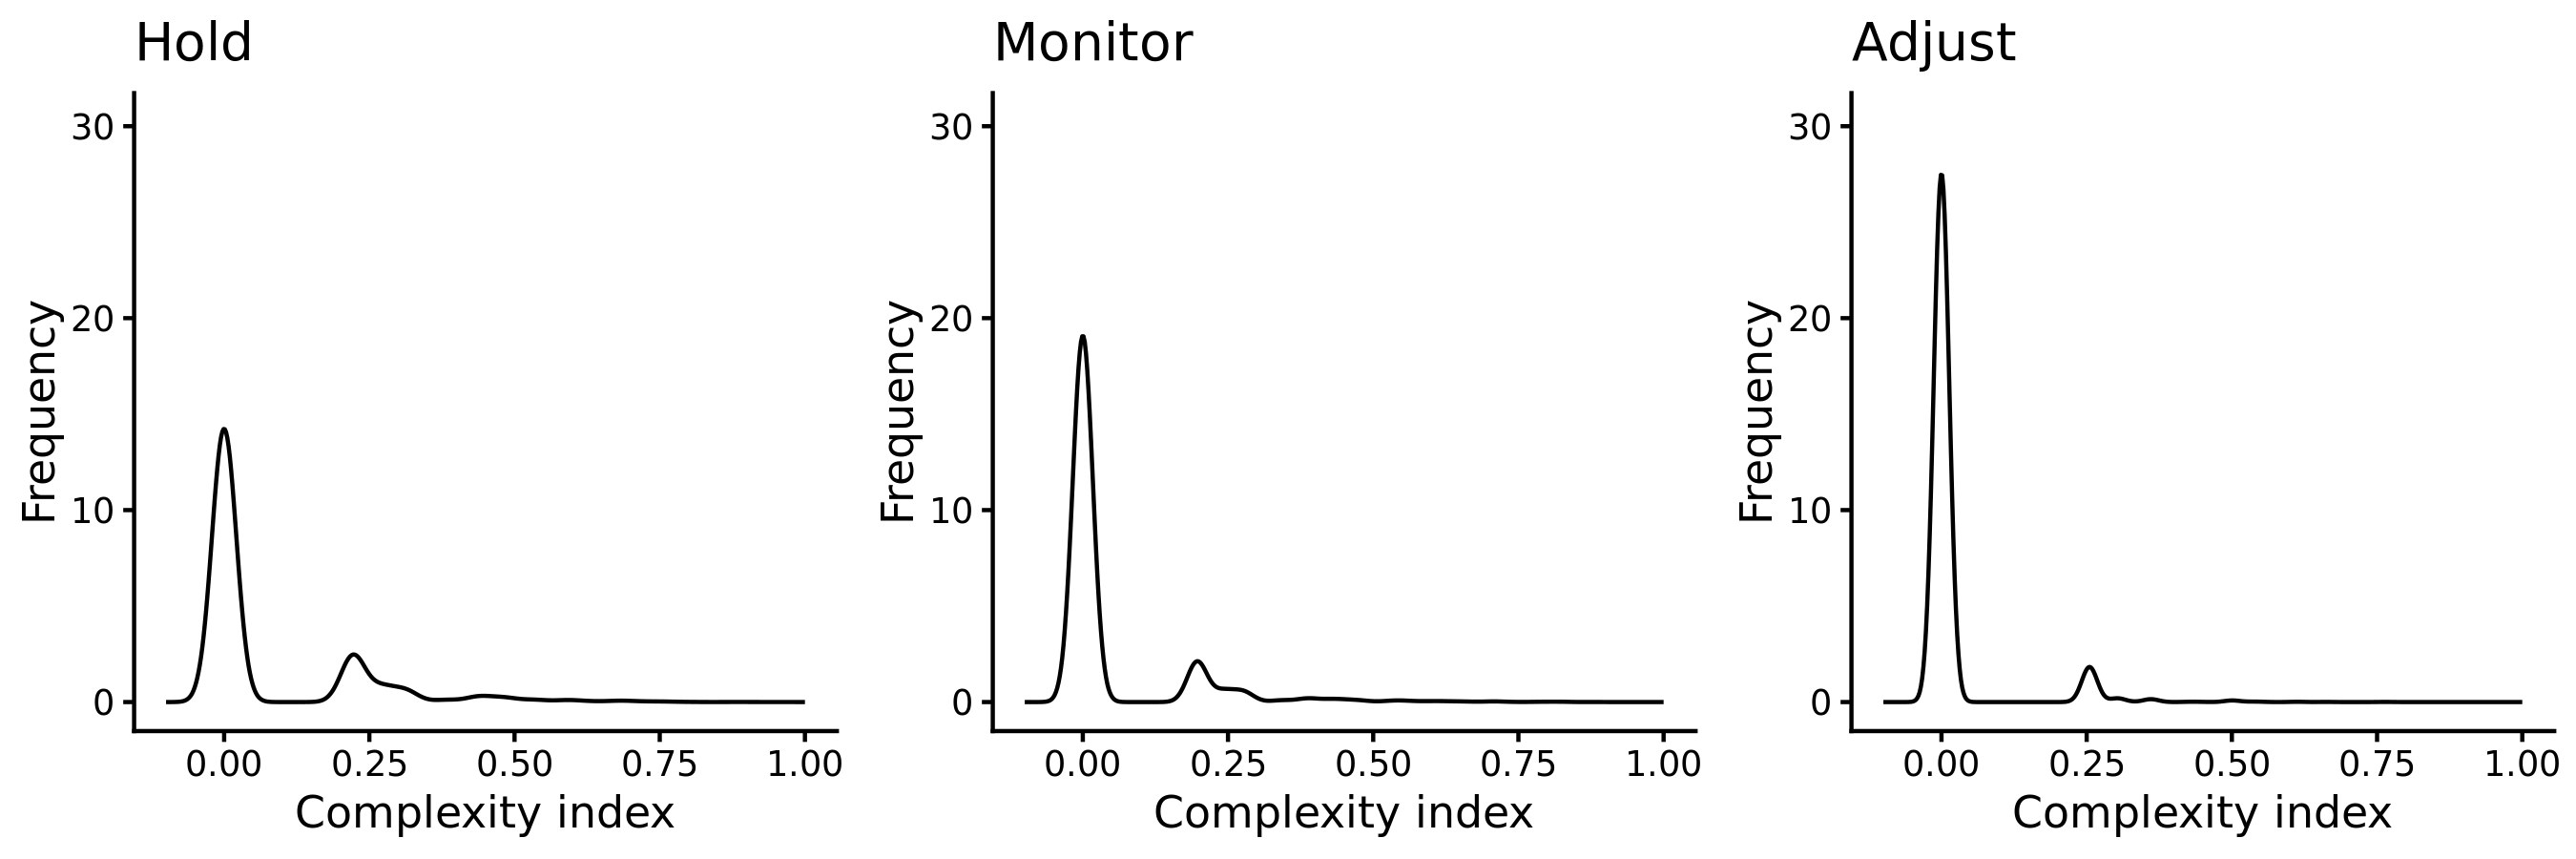

In [28]:
plot_sequenceComplexity_test_only_Hold_density <-
    seq_complexity_test_only_Hold %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_density( aes( C ), colour = "black" ) +
    labs( title = "Hold", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()
plot_sequenceComplexity_test_only_Monitor_density <-
    seq_complexity_test_only_Monitor %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_density( aes( C ), colour = "black" ) +
    labs( title = "Monitor", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()
plot_sequenceComplexity_test_only_Adjust_density <-
    seq_complexity_test_only_Adjust %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_density( aes( C ), colour = "black" ) +
    labs( title = "Adjust", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()


y_top_value <-
    dplyr::bind_rows(
        ggplot2::layer_data( plot_sequenceComplexity_test_only_Hold_density ) %>% dplyr::summarise( max = max( density ) )
        ,ggplot2::layer_data( plot_sequenceComplexity_test_only_Monitor_density ) %>% dplyr::summarise( max = max( density ) )
        ,ggplot2::layer_data( plot_sequenceComplexity_test_only_Adjust_density ) %>% dplyr::summarise( max = max( density ) )
    ) %>%
    dplyr::summarise( max = max( max ) ) %>%
    `*`( 1.1 )%>%
    dplyr::pull()

# Plot histograms.
options( repr.plot.width = 9, repr.plot.height = 3, repr.plot.res = 300 )
plot_sequenceComplexity_test_only_excludingUnobserved_stratified_density <- 
    cowplot::plot_grid(
        plot_sequenceComplexity_test_only_Hold_density + ylim( 0, y_top_value )
        ,plot_sequenceComplexity_test_only_Monitor_density + ylim( 0, y_top_value )
        ,plot_sequenceComplexity_test_only_Adjust_density + ylim( 0, y_top_value )
        ,nrow = 1
    )

suppressWarnings( print( plot_sequenceComplexity_test_only_excludingUnobserved_stratified_density ) )

The plots show:

1. __Subsequences in all states are predominantly of minimal complexity.__
    - Evidenced by the largest column at 0.
<br></br>

2. __Almost all healthcare records are of moderate to low complexity.__
    - Evidenced by columns mainly in the range of 0-0.5 for all states.
<br></br>

3. __The 'Adjust' state is the least complex state.__
    - \[not shown\] Evidenced by the peak in the density plot of complexity-index values at 0 being noticably larger in the 'Adjust' state.
<br></br>

<br></br>
The state-specific complexity distributions are similar but sparser compared to the first plot showing the complexity of sequences irrespective of states. It must be acknowledged that subsequences are shorter than the the full sequence from a record so there is less opportunity for changes that would contribute to larger values of complexity. (Note that the opportunity for change before a state change is a different concept to the probability of change with respect to the length of a sequence, the latter of which is accounted for in the calculation.)

Another explanation for the sparsity could be that test statuses change in coincidence with changes in state rather than during period of stable states. To begin to investigate this explanation, below, I reshow the distribution plot of complexity irrespective of state (left) alongside a plot of complexity for states (right).

In [29]:
# Calculate statistics over all patient records.
sts_seqmine_HMA[sts_seqmine_HMA == "Unobserved"] <- NA
seq_complexity_HMA_only <- TraMineR::seqici( sts_seqmine_HMA )

# Create table of summary statistics.
plot_table <-
   seq_complexity_HMA_only %>%
    as.data.frame() %>%
    dplyr::summarise(
        min = min( C )
        ,`1st qtr` = quantile( C, 0.25 )
        ,mean = mean( C )
        ,median = median( C )
        ,`3rd qtr` = quantile( C, 0.75 )
        ,max = max( C )
    ) %>%
    base::round(2) %>%
    t()

# Plot histograms and summary statistics.
options( repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300 )
n_bins <- 20
plot_sequenceComplexity_HMA <-
    seq_complexity_HMA_only %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( C ), bins = n_bins, colour = "black", position = "dodge" ) +
    labs( title = "State sequences", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    annotation_custom( tableGrob( plot_table ), xmin = 0.5, xmax = 1, ymin = 500, ymax = 2500 ) +
    theme_classic()

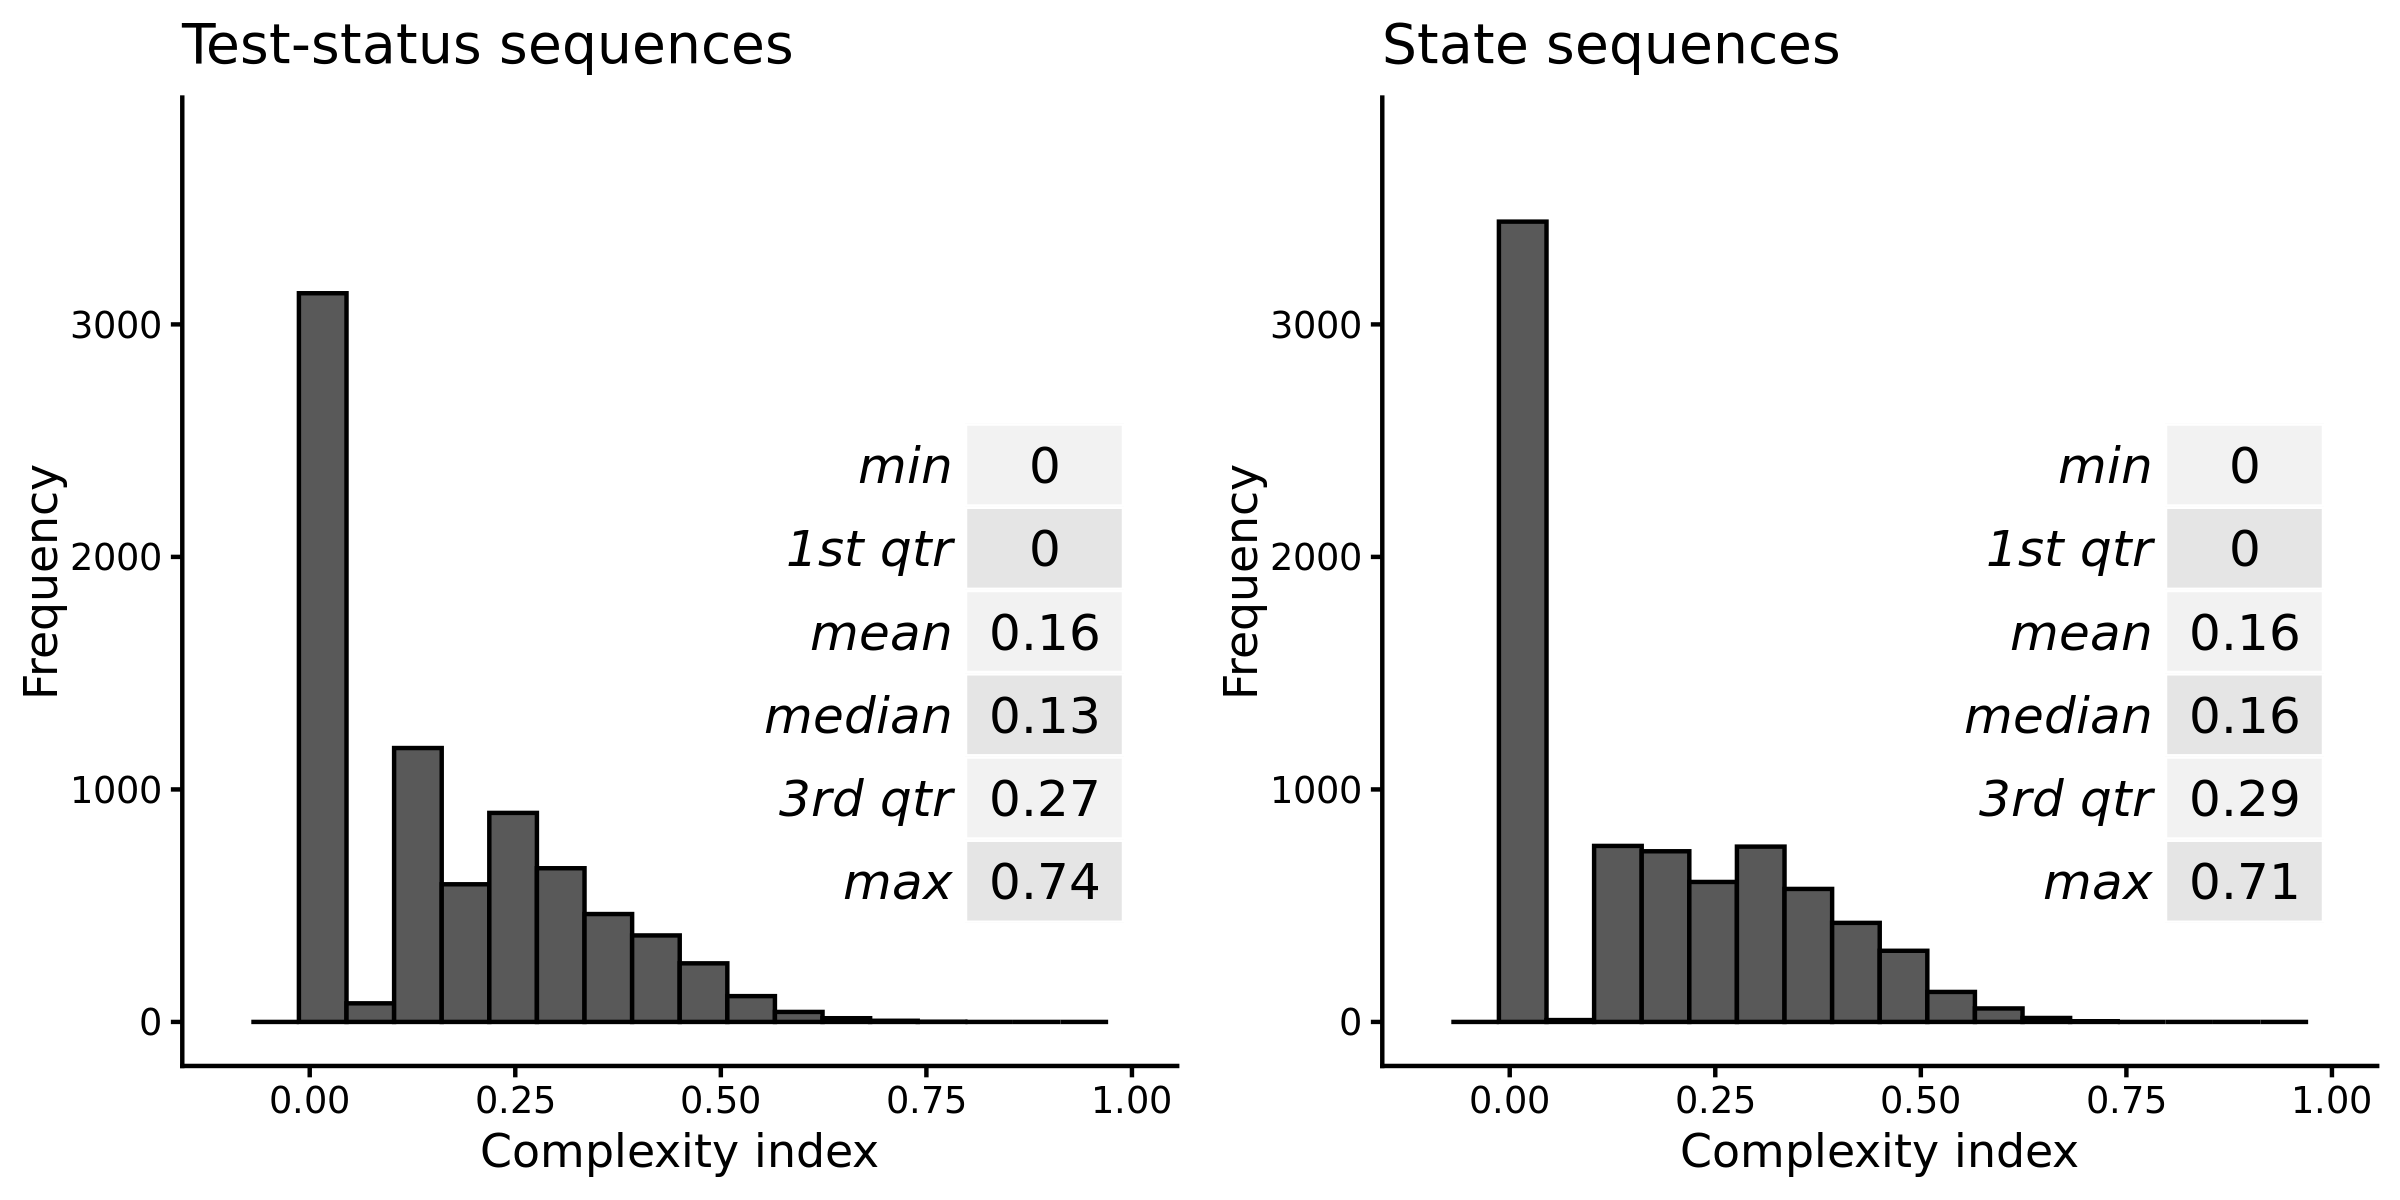

In [30]:
y_top_value <-
    dplyr::bind_rows(
        ggplot2::layer_data( plot_sequenceComplexity_test_only ) %>% dplyr::summarise( max = max( count ) )
        ,ggplot2::layer_data( plot_sequenceComplexity_HMA ) %>% dplyr::summarise( max = max( count ) )
    ) %>%
    dplyr::summarise( max = max( max ) ) %>%
    `*`( 1.1 )%>%
    dplyr::pull()

# Plot histograms and summary statistics.
options( repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 300 )
suppressWarnings(
    print(
        cowplot::plot_grid(
            plot_sequenceComplexity_test_only + ylim( 0, y_top_value )
            ,plot_sequenceComplexity_HMA + ylim( 0, y_top_value )
            ,nrow = 1
            )
        )
    )

The plots show:
- The distributional summary statistics (min, mean, etc.) are almost identical.
- The shape of the distributions are very similar to each other.
<br></br>

This could be evidence that the changes in test statuses are mostly coincident with the changes in states. If this were the case, then the complexity of subsequences of states should be similar in each of the test-status-specific distributions.

_Note_: Large values would indicate ineffective changes to testing and treatment because it indicates changes to state despite no change to test status.

In [31]:
# Cut the data by test status.
df_seq_test_only_stratified_testStatus <-
    df_seq_test_only %>%
    dplyr::select( person_id, HMA, event_value, rn ) %>%
    base::split( .$event_value)

# Convert the time series dataframe to a state sequence object.
# ## Red
person_subsequences_Red <- 
    df_seq_test_only_stratified_testStatus$`Test Status = Red` %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate(
        diff = rn - lag( rn, default = first( rn ) )
        ,is_new_group = diff != 1
        ,pseq_increment = cumsum( is_new_group )
        ,pseq_id = paste0( person_id, "_", pseq_increment )
    ) %>%
    dplyr::ungroup() %>%
    dplyr::group_by( person_id, pseq_increment ) %>%
    dplyr::mutate( pseq_rn = row_number() ) %>%
    as.data.frame() %>%
    dplyr::select( - c( person_id, diff, is_new_group ) )
d_Red <- 
     TraMineRextras::TSE_to_STS(
                person_subsequences_Red
                ,id = "pseq_id"
                ,timestamp = "pseq_rn"
                ,event = "HMA"
                ,stm = stm_HMA
                ,tmax = person_subsequences_Red %>% dplyr::select( pseq_increment ) %>% dplyr::ungroup() %>% max()
                ) %>%
                dplyr::select( - a1 )
statl <- TraMineR:::seqxtract( d_Red, NULL, data.frame = TRUE ) %>% seqstatl()
sts_seqmine_test_only_Red <-
    d_Red %>%
    TraMineR::seqdef( labels = statl) %>%
    suppressMessages()
rm( d_Red )

# ## Amber
person_subsequences_Amber <- 
    df_seq_test_only_stratified_testStatus$`Test Status = Amber` %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate(
        diff = rn - lag( rn, default = first( rn ) )
        ,is_new_group = diff != 1
        ,pseq_increment = cumsum( is_new_group )
        ,pseq_id = paste0( person_id, "_", pseq_increment )
    ) %>%
    dplyr::ungroup() %>%
    dplyr::group_by( person_id, pseq_increment ) %>%
    dplyr::mutate( pseq_rn = row_number() ) %>%
    as.data.frame() %>%
    dplyr::select( - c( person_id, diff, is_new_group ) )
d_Amber <- 
     TraMineRextras::TSE_to_STS(
                person_subsequences_Amber
                ,id = "pseq_id"
                ,timestamp = "pseq_rn"
                ,event = "HMA"
                ,stm = stm_HMA
                ,tmax = person_subsequences_Amber %>% dplyr::select( pseq_increment ) %>% dplyr::ungroup() %>% max()
                ) %>%
                dplyr::select( - a1 )
statl <- TraMineR:::seqxtract( d_Amber, NULL, data.frame = TRUE ) %>% seqstatl()
sts_seqmine_test_only_Amber <-
    d_Amber %>%
    TraMineR::seqdef( labels = statl) %>%
    suppressMessages()
rm( d_Amber )

# ## Yellow
person_subsequences_Yellow <- 
    df_seq_test_only_stratified_testStatus$`Test Status = Yellow` %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate(
        diff = rn - lag( rn, default = first( rn ) )
        ,is_new_group = diff != 1
        ,pseq_increment = cumsum( is_new_group )
        ,pseq_id = paste0( person_id, "_", pseq_increment )
    ) %>%
    dplyr::ungroup() %>%
    dplyr::group_by( person_id, pseq_increment ) %>%
    dplyr::mutate( pseq_rn = row_number() ) %>%
    as.data.frame() %>%
    dplyr::select( - c( person_id, diff, is_new_group ) )
d_Yellow <- 
     TraMineRextras::TSE_to_STS(
                person_subsequences_Yellow
                ,id = "pseq_id"
                ,timestamp = "pseq_rn"
                ,event = "HMA"
                ,stm = stm_HMA
                ,tmax = person_subsequences_Yellow %>% dplyr::select( pseq_increment ) %>% dplyr::ungroup() %>% max()
                ) %>%
                dplyr::select( - a1 )
statl <- TraMineR:::seqxtract( d_Yellow, NULL, data.frame = TRUE ) %>% seqstatl()
sts_seqmine_test_only_Yellow <-
    d_Yellow %>%
    TraMineR::seqdef( labels = statl) %>%
    suppressMessages()
rm( d_Yellow )

# ## Green
person_subsequences_Green <- 
    df_seq_test_only_stratified_testStatus$`Test Status = Green` %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate(
        diff = rn - lag( rn, default = first( rn ) )
        ,is_new_group = diff != 1
        ,pseq_increment = cumsum( is_new_group )
        ,pseq_id = paste0( person_id, "_", pseq_increment )
    ) %>%
    dplyr::ungroup() %>%
    dplyr::group_by( person_id, pseq_increment ) %>%
    dplyr::mutate( pseq_rn = row_number() ) %>%
    as.data.frame() %>%
    dplyr::select( - c( person_id, diff, is_new_group ) )
d_Green <- 
     TraMineRextras::TSE_to_STS(
                person_subsequences_Green
                ,id = "pseq_id"
                ,timestamp = "pseq_rn"
                ,event = "HMA"
                ,stm = stm_HMA
                ,tmax = person_subsequences_Green %>% dplyr::select( pseq_increment ) %>% dplyr::ungroup() %>% max()
                ) %>%
                dplyr::select( - a1 )
statl <- TraMineR:::seqxtract( d_Green, NULL, data.frame = TRUE ) %>% seqstatl()
sts_seqmine_test_only_Green <-
    d_Green %>%
    TraMineR::seqdef( labels = statl) %>%
    suppressMessages()
rm( d_Green )

In [32]:
# Calculate statistics over all patient records.
seq_complexity_test_only_Green <- TraMineR::seqici( sts_seqmine_test_only_Green )

# Plot histograms and summary statistics.
n_bins <- 20
plot_sequenceComplexity_test_only_Green <-
    seq_complexity_test_only_Green %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( C ), bins = n_bins, colour = "black", position = "dodge" ) +
    labs( title = "Green", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()

In [33]:
# Calculate statistics over all patient records.
seq_complexity_test_only_Yellow <- TraMineR::seqici( sts_seqmine_test_only_Yellow )

# Plot histograms and summary statistics.
n_bins <- 20
plot_sequenceComplexity_test_only_Yellow <-
    seq_complexity_test_only_Yellow %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( C ), bins = n_bins, colour = "black", position = "dodge" ) +
    labs( title = "Yellow", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()

In [34]:
# Calculate statistics over all patient records.
seq_complexity_test_only_Amber <- TraMineR::seqici( sts_seqmine_test_only_Amber )

# Plot histograms and summary statistics.
n_bins <- 20
plot_sequenceComplexity_test_only_Amber<-
    seq_complexity_test_only_Amber %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( C ), bins = n_bins, colour = "black", position = "dodge" ) +
    labs( title = "Amber", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()

In [35]:
# Calculate statistics over all patient records.
seq_complexity_test_only_Red <- TraMineR::seqici( sts_seqmine_test_only_Red )

# Plot histograms and summary statistics.
n_bins <- 20
plot_sequenceComplexity_test_only_Red <-
    seq_complexity_test_only_Red %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( C ), bins = n_bins, colour = "black", position = "dodge" ) +
    labs( title = "Red", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


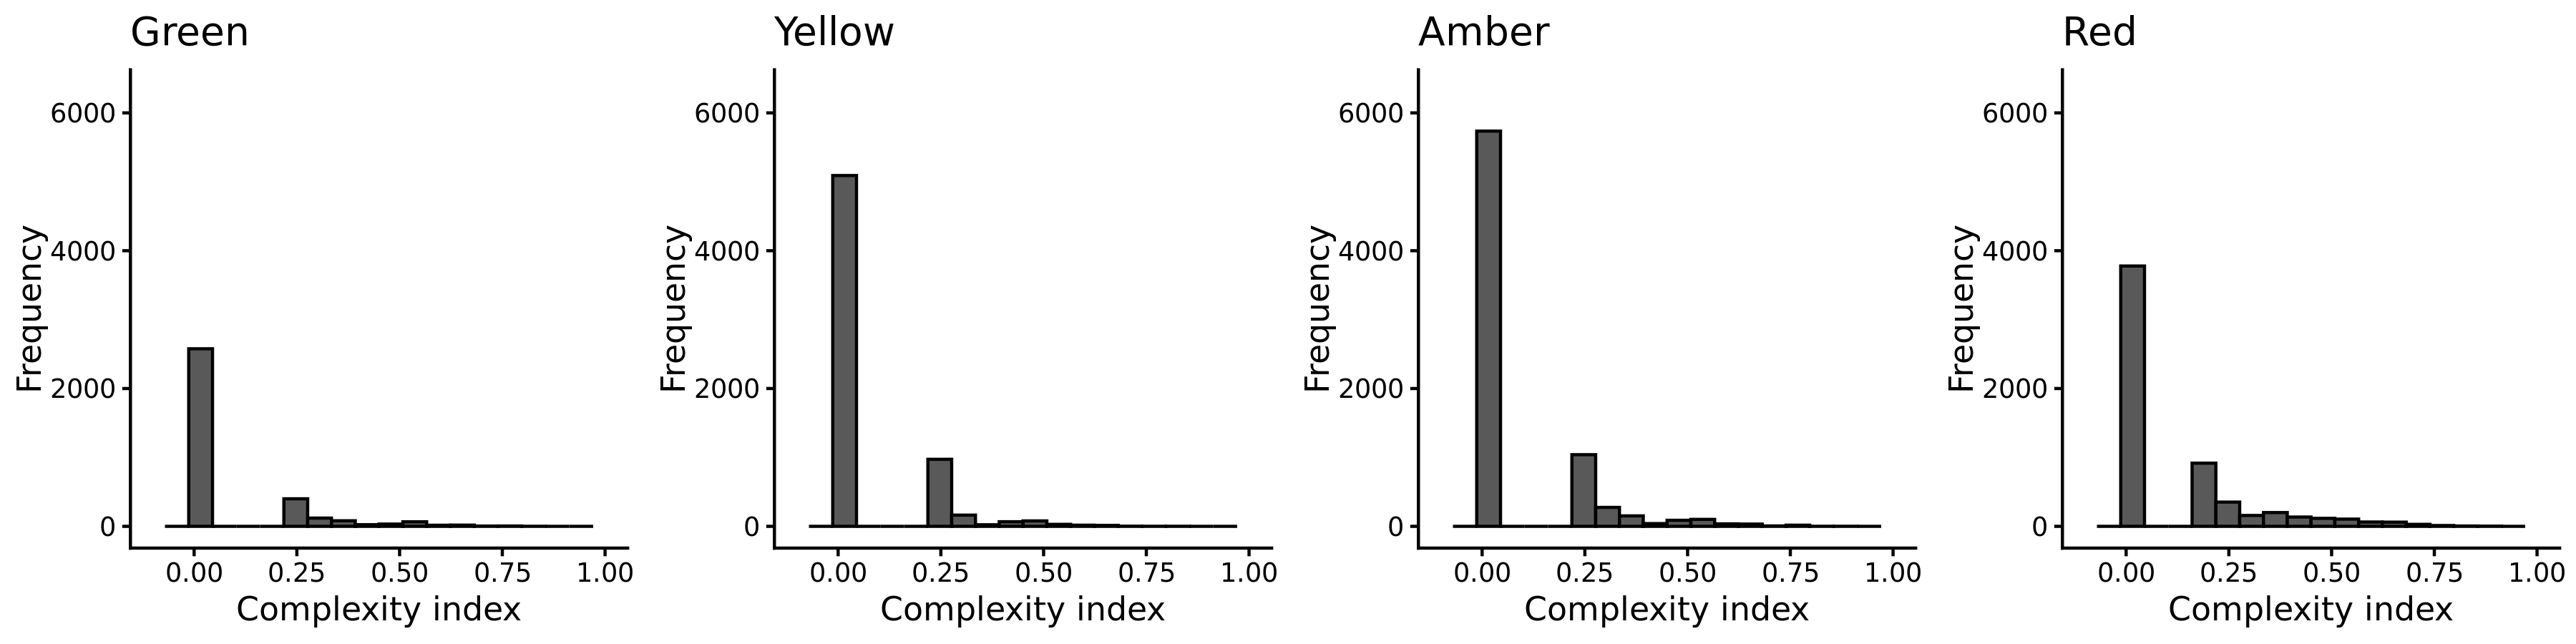

In [36]:
y_top_value <-
    dplyr::bind_rows(
        ggplot2::layer_data( plot_sequenceComplexity_test_only_Green ) %>% dplyr::summarise( max = max( count ) )
        ,ggplot2::layer_data( plot_sequenceComplexity_test_only_Yellow ) %>% dplyr::summarise( max = max( count ) )
        ,ggplot2::layer_data( plot_sequenceComplexity_test_only_Amber ) %>% dplyr::summarise( max = max( count ) )
        ,ggplot2::layer_data( plot_sequenceComplexity_test_only_Red ) %>% dplyr::summarise( max = max( count ) )
    ) %>%
    dplyr::summarise( max = max( max ) ) %>%
    `*`( 1.1 )%>%
    dplyr::pull()

# Plot histograms.
options( repr.plot.width = 12, repr.plot.height = 3, repr.plot.res = 300 )
plot_sequenceComplexity_test_only_excludingUnobserved_stratified_testStatuses <- 
    cowplot::plot_grid(
        plot_sequenceComplexity_test_only_Green + ylim( 0, y_top_value )
        ,plot_sequenceComplexity_test_only_Yellow + ylim( 0, y_top_value )
        ,plot_sequenceComplexity_test_only_Amber + ylim( 0, y_top_value )
        ,plot_sequenceComplexity_test_only_Red + ylim( 0, y_top_value )
        ,nrow = 1
    )

suppressWarnings( print( plot_sequenceComplexity_test_only_excludingUnobserved_stratified_testStatuses ) )

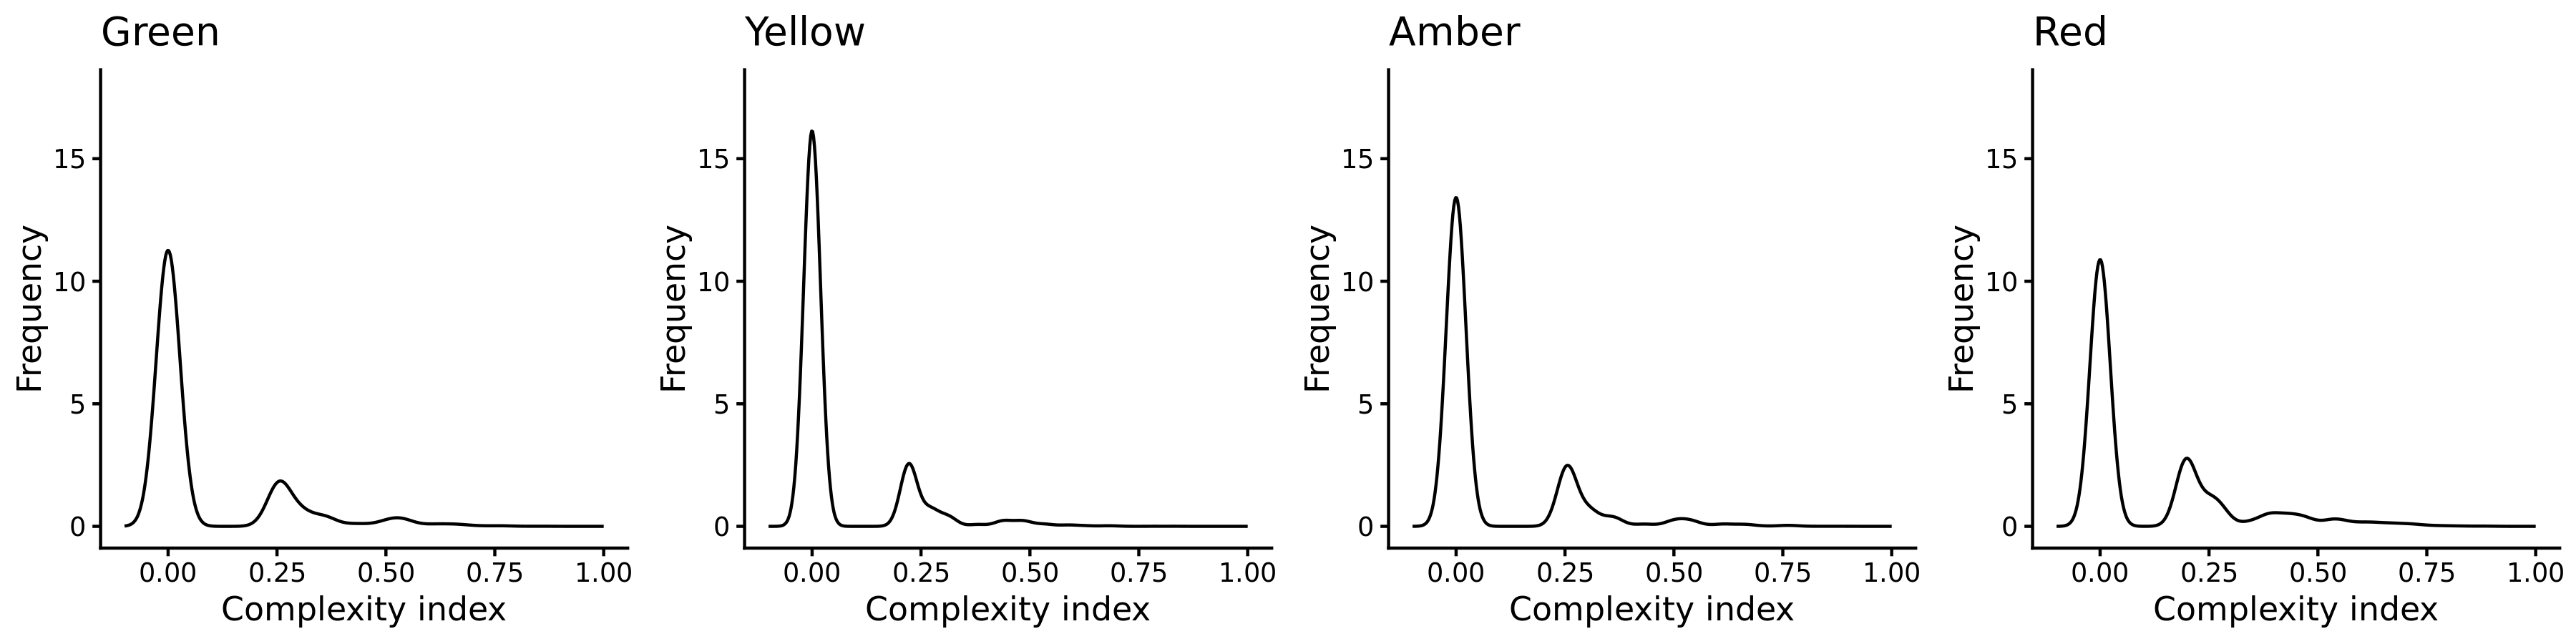

In [37]:
plot_sequenceComplexity_test_only_Green_density <-
    seq_complexity_test_only_Green %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_density( aes( C ), colour = "black" ) +
    labs( title = "Green", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()
plot_sequenceComplexity_test_only_Yellow_density <-
    seq_complexity_test_only_Yellow %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_density( aes( C ), colour = "black" ) +
    labs( title = "Yellow", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()
plot_sequenceComplexity_test_only_Amber_density <-
    seq_complexity_test_only_Amber %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_density( aes( C ), colour = "black" ) +
    labs( title = "Amber", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()
plot_sequenceComplexity_test_only_Red_density <-
    seq_complexity_test_only_Red %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_density( aes( C ), colour = "black") +
    labs( title = "Red", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()

y_top_value <-
    dplyr::bind_rows(
        ggplot2::layer_data( plot_sequenceComplexity_test_only_Green_density ) %>% dplyr::summarise( max = max( density ) )
        ,ggplot2::layer_data( plot_sequenceComplexity_test_only_Yellow_density ) %>% dplyr::summarise( max = max( density ) )
        ,ggplot2::layer_data( plot_sequenceComplexity_test_only_Amber_density ) %>% dplyr::summarise( max = max( density ) )
        ,ggplot2::layer_data( plot_sequenceComplexity_test_only_Red_density ) %>% dplyr::summarise( max = max( density ) )
    ) %>%
    dplyr::summarise( max = max( max ) ) %>%
    `*`( 1.1 )%>%
    dplyr::pull()

# Plot histograms.
options( repr.plot.width = 12, repr.plot.height = 3, repr.plot.res = 300 )
plot_sequenceComplexity_test_only_excludingUnobserved_stratified_testStatuses_density <- 
    cowplot::plot_grid(
        plot_sequenceComplexity_test_only_Green_density + ylim( 0, y_top_value )
        ,plot_sequenceComplexity_test_only_Yellow_density + ylim( 0, y_top_value )
        ,plot_sequenceComplexity_test_only_Amber_density + ylim( 0, y_top_value )
        ,plot_sequenceComplexity_test_only_Red_density + ylim( 0, y_top_value )
        ,nrow = 1
    )

suppressWarnings( print( plot_sequenceComplexity_test_only_excludingUnobserved_stratified_testStatuses_density ) )

The plots show:
- Subsequences in all test statuses are predominantly of minimal complexity. This makes sense given that most subsequences are short, which doesn't provide much opportunity for complexity to arise.
- Moderate complexity-index values are found in all test statuses.
- A greater proportion of ‘Red’ test-status subsequences show greater complexity.
<br></br>
<br></br>

Let us consider the following findings, together:
1. The distribution of the complexity of sequences of test statuses is very similar to the distribution of sequences of states.
2. The distribution of the complexity of sequences of test statuses in stratifications of states is mostly low and sparse across the rest of the range.
3. The distribution of the complexity of sequences of states in stratifications of test statuses is mostly low and sparse across the rest of the range.

__These findings are compatible with the conjecture that the changes in test status are coincident with changes in state. If we also consider the temporal logic implying that the test statuses influence the states, we can conclude that changes in test status are the main driver of changes in state.__

# Other CB tasks

## HbA1c density plot, stratified by HMA

In [133]:
options( repr.plot.width = 5, repr.plot.height = 25, repr.plot.res = 300 )

p <-
df_log_PandT_longFormat_simplified_StrataLabels %>%
dplyr::select( person_id, idx_test_interval, HMA, HbA1c ) %>%
dplyr::filter( !is.na( HbA1c ) ) %>%
ggplot( aes( group = HMA, colour = HMA, fill = HMA ) ) +
geom_density( aes( x = HbA1c ), alpha = 0.2 ) +
# Colour the strata using a traffic-light palette.
scale_colour_manual(
    values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
) +
scale_fill_manual(
    values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
    ,labels = c( "Hold", "Monitor", "Adjust", "NA" )
    ,name = NULL
) +
scale_x_continuous( sec.axis = dup_axis() ) +
guides( colour = 'none' ) +
facet_wrap(~  idx_test_interval, ncol = 1 ) +
theme_bw() +
theme( legend.position = "top", axis.text.y = element_blank() )

ggsave(
    filename = "HbA1c distributions stratified by HMA, facetted by test number.jpg"
    ,plot = p
    ,width = 10
    ,height = 100
    ,dpi = 300
    ,units = "cm"
)

In [134]:
options( repr.plot.width = 5, repr.plot.height = 25, repr.plot.res = 300 )

p <-
df_log_PandT_longFormat_simplified_StrataLabels %>%
dplyr::select( person_id, idx_test_interval, HMA, HbA1c ) %>%
dplyr::filter( !is.na( HbA1c ) ) %>%
dplyr::group_by( person_id ) %>%
dplyr::mutate( delta_HbA1c = lead( HbA1c ) - HbA1c ) %>%
tidyr::drop_na() %>%
ggplot( aes( group = HMA, colour = HMA, fill = HMA ) ) +
geom_density( aes( x = delta_HbA1c ), alpha = 0.2 ) +
labs( x = "\u0394 HbA1c") +
scale_colour_manual(
    values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
) +
scale_fill_manual(
    values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
    ,labels = c( "Hold", "Monitor", "Adjust", "NA" )
    ,name = NULL
) +
scale_x_continuous( sec.axis = dup_axis() ) +
guides( colour = 'none' ) +
facet_wrap(~ idx_test_interval + HMA , ncol = 3 ) +
theme_bw() +
theme( legend.position = "top", axis.text.y = element_blank() )

ggsave(
    filename = "Change in HbA1c distributions stratified by HMA, facetted by test number.jpg"
    ,plot = p
    ,width = 10
    ,height = 100
    ,dpi = 300
    ,units = "cm"
)

## Trace variants

Make dataframes.

In [7]:
# I will need to identify the `person_id` in `df_log_PandT_longFormat_simplified_StrataLabels` and then filter the STS object for those ID numbers.

pids_temp <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    # Select columns of interest.
    dplyr::select( person_id, idx_test_interval, event_name, HMA ) %>%
    # Filter for test events with valid values for the inter-test interval.
    dplyr::filter( event_name == "test", !is.na( HMA ) ) %>%
    # Define the criteria where a person's record is valid.
    dplyr::group_by( person_id ) %>%
    dplyr::arrange( idx_test_interval, .by_group = TRUE ) %>%
    dplyr::mutate(
        start_from_1 = dplyr::first( idx_test_interval == 1 )
        ,consecutive = ( ( idx_test_interval - lag( idx_test_interval ) ) == 1 )
        ,consecutive = dplyr::if_else( is.na( consecutive ), TRUE, consecutive )
    ) %>%
    dplyr::rowwise() %>%
    dplyr::mutate( consecutive_and_starts_from_1 = all( start_from_1, consecutive ) ) %>%
    dplyr::ungroup()

pids_atLeast_5 <-
    pids_temp %>%
    dplyr::group_by( person_id ) %>%
    dplyr::filter( ( max( idx_test_interval ) >= 5 ), all( consecutive_and_starts_from_1 ) ) %>%
    dplyr::ungroup() %>%
    dplyr::pull( person_id )
pids_atLeast_10 <-
    pids_temp %>%
    dplyr::group_by( person_id ) %>%
    dplyr::filter( ( max( idx_test_interval ) >= 10 ), all( consecutive_and_starts_from_1 ) ) %>%
    dplyr::ungroup() %>%
    dplyr::pull( person_id )
pids_atLeast_15 <-
    pids_temp %>%
    dplyr::group_by( person_id ) %>%
    dplyr::filter( ( max( idx_test_interval ) >= 15 ), all( consecutive_and_starts_from_1 ) ) %>%
    dplyr::ungroup() %>%
    dplyr::pull( person_id )

rm( pids_temp )

Make function that creates the activity log and calculates the coverage statistics.

In [88]:
fnc__calculatecoveragestats <- function(
    pids = NULL
)
    {
    
    # Make the activity log.
    p <-
        df_log_PandT_longFormat_simplified_StrataLabels %>%
        dplyr::filter( person_id %in% pids, !is.na( HbA1c ) ) %>%
        dplyr::select( person_id, HMA, start_dttm ) %>%
        dplyr::rename( start = start_dttm ) %>%
        dplyr::group_by( person_id ) %>%
        dplyr::arrange( person_id, start ) %>%
        dplyr::mutate( .order = row_number() ) %>%
        dplyr::ungroup() %>%
        bupaR::activitylog(
            case_id = "person_id"
            ,activity_id = "HMA"
            ,resource_id = "person_id"
            ,timestamps = "start"
            ,order = "sorted"
        ) 
    
    # Calculate coverage statistics. These show how often a given sequence occured, its relative proportion, and the cumulative proportion from the most frequent upward.
    coverage_states <-
        p %>%
        dplyr::select( person_id, HMA) %>%
        dplyr::summarise( trace = toString( HMA ), .by = person_id ) %>%
        dplyr::summarise( absolute = n(), .by = trace ) %>%
        dplyr::mutate(
            relative = absolute / n()
            ,cumulative = cumsum( relative )
        ) %>%
        dplyr::arrange( - absolute, trace ) %>%
        head()
    
    return( coverage_states )
}
    

Top 6 most-frequent traces from sequences with at least 5 events.

In [89]:
fnc__calculatecoveragestats( pids_atLeast_5 )

trace,absolute,relative,cumulative
<chr>,<int>,<dbl>,<dbl>
"Hold, Hold, Hold, Hold, Hold, NA",52,0.043333333,0.07916667
"Hold, Hold, Hold, Hold, Hold, Hold, NA",28,0.023333333,0.03166667
"Hold, Hold, Hold, Hold, Adjust",15,0.012500000,0.30250000
"Adjust, Hold, Hold, Hold, Hold, NA",8,0.006666667,0.14250000
"Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, NA",8,0.006666667,0.13166667
"Hold, Hold, Hold, Hold, Monitor, NA",8,0.006666667,0.42000000


Top 6 most-frequent traces from sequences with at least 10 events.

In [90]:
fnc__calculatecoveragestats( pids_atLeast_10 )

trace,absolute,relative,cumulative
<chr>,<int>,<dbl>,<dbl>
"Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, NA",3,0.007075472,0.1580189
"Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, NA",3,0.007075472,0.1438679
"Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, NA",3,0.007075472,0.1367925
"Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Monitor, Hold, Hold, Hold, Hold, NA",3,0.007075472,0.3820755
"Adjust, Hold, Hold, Monitor, Hold, Monitor, Hold, Hold, Hold, Hold, NA",2,0.004716981,0.4882075
"Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, NA",2,0.004716981,0.5589623


Top 6 most-frequent traces from sequences with at least 15 events.

In [91]:
fnc__calculatecoveragestats( pids_atLeast_15 )

trace,absolute,relative,cumulative
<chr>,<int>,<dbl>,<dbl>
"Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, NA",3,0.01863354,0.16770186
"Adjust, Adjust, Adjust, Adjust, Monitor, Hold, Monitor, Monitor, Monitor, Monitor, Monitor, Hold, Hold, Monitor, Monitor, Monitor, NA",1,0.00621118,0.53416149
"Adjust, Adjust, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, NA",1,0.00621118,0.08074534
"Adjust, Adjust, Hold, Hold, Hold, Hold, Hold, Monitor, Monitor, Monitor, Monitor, Hold, Hold, Hold, Monitor, NA",1,0.00621118,0.79503106
"Adjust, Adjust, Hold, Hold, Hold, Monitor, Adjust, Monitor, Hold, Monitor, Monitor, Hold, Monitor, Hold, Hold, Hold, Hold, Hold, Monitor, Hold, NA",1,0.00621118,0.06832298
"Adjust, Hold, Adjust, Adjust, Hold, Adjust, Hold, Adjust, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Hold, Monitor, Hold, NA",1,0.00621118,0.96894410


## The relationship between the rate of state switching and the number of test events

In [117]:
fnc__plotcountandchanges <- function(
    pids = NULL
    ,dataset.name = NULL
)
    {
    
        df_log_PandT_longFormat_simplified_StrataLabels %>%
        dplyr::filter( person_id %in% pids ) %>%
        dplyr::distinct( person_id, idx_test_interval, HMAandTestStatus ) %>%
        dplyr::mutate(
            changes = lead( HMAandTestStatus ) == HMAandTestStatus
            ,.by = person_id
        ) %>%
        dplyr::summarise(
            n_tests = max( idx_test_interval )
            ,change_count = sum( changes, na.rm = TRUE )
            ,.by = person_id
        ) %>%
        ggplot() +
        geom_point( aes( x = n_tests, y = change_count ) ) +
        labs(
            x = "Count of tests observed"
            ,y = "Count of changes\nbetween state"
            ,title =  "(Lack of) Relationship between the\ncount of tests and count of\nchanges of state."
            ,subtitle = dataset.name
        ) +
        theme_minimal()
    }

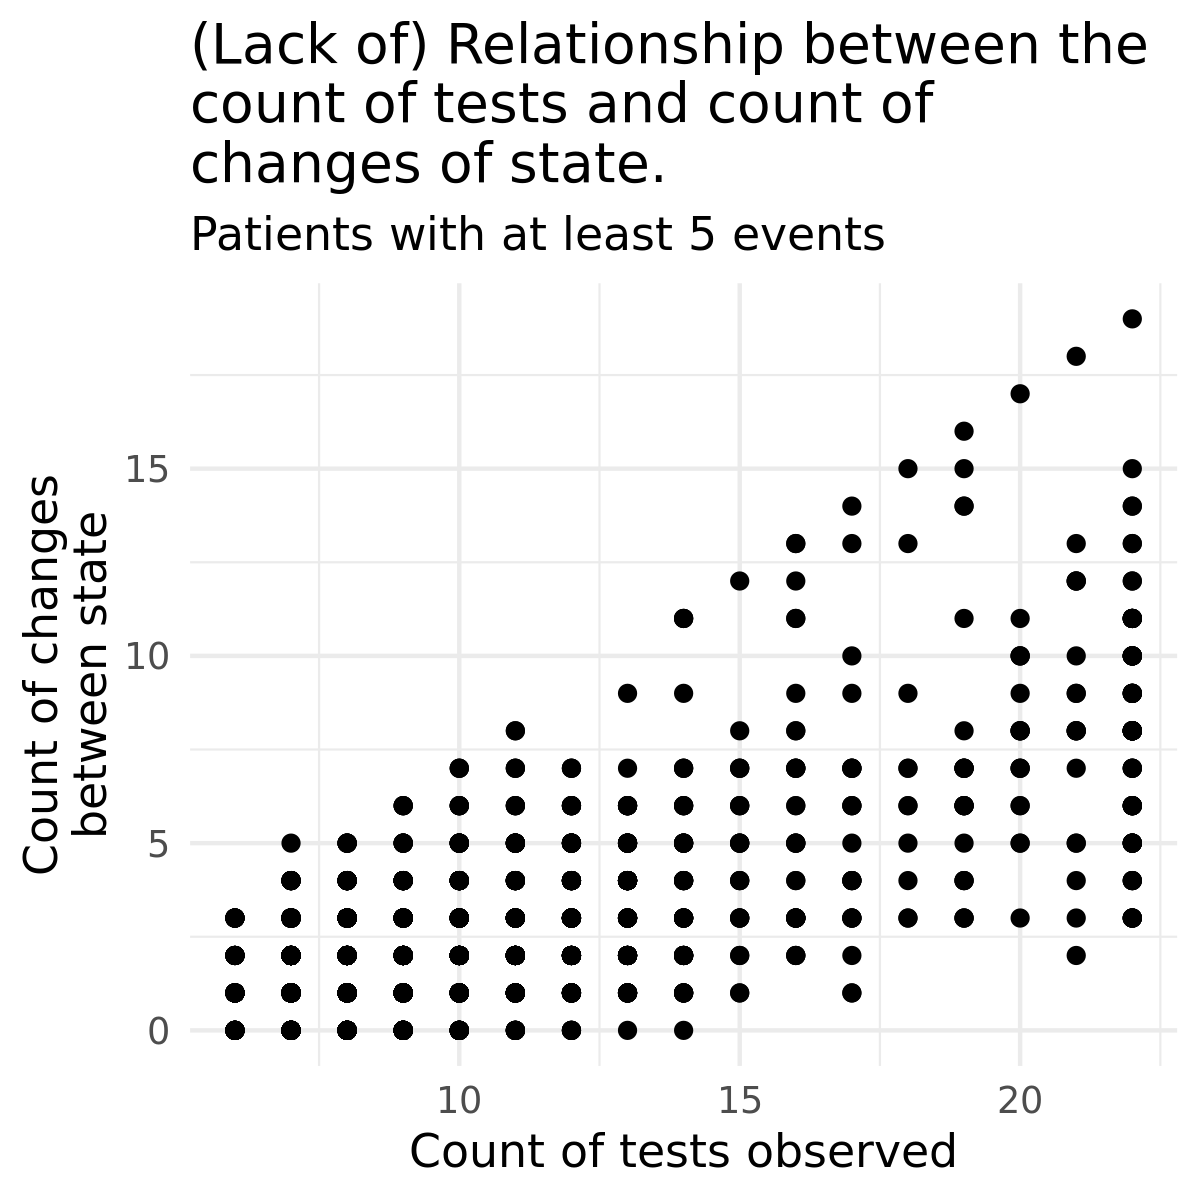

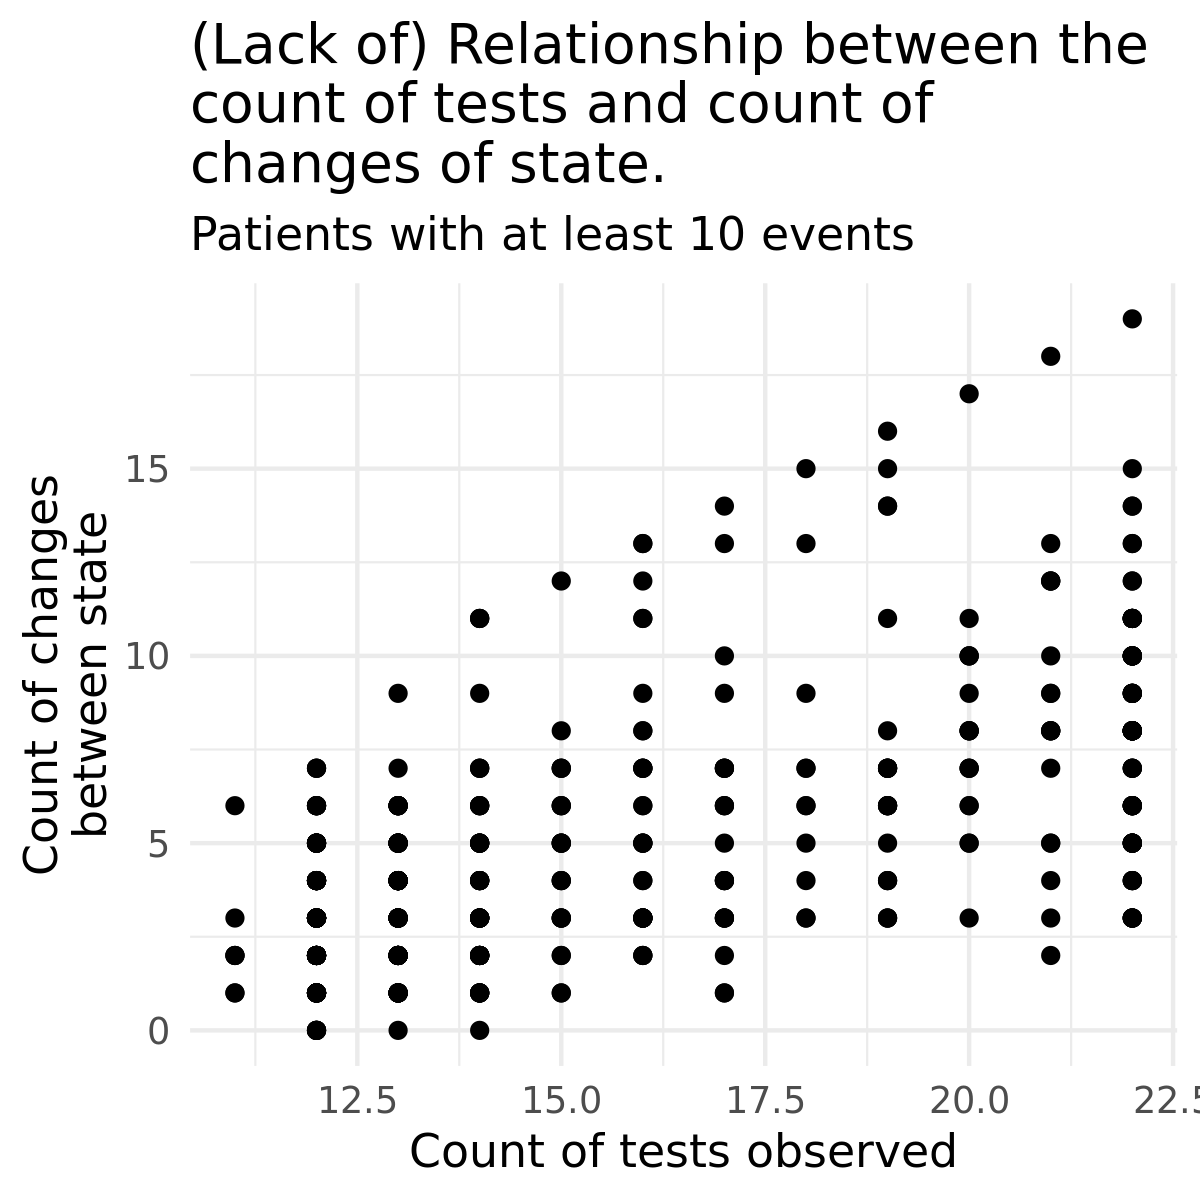

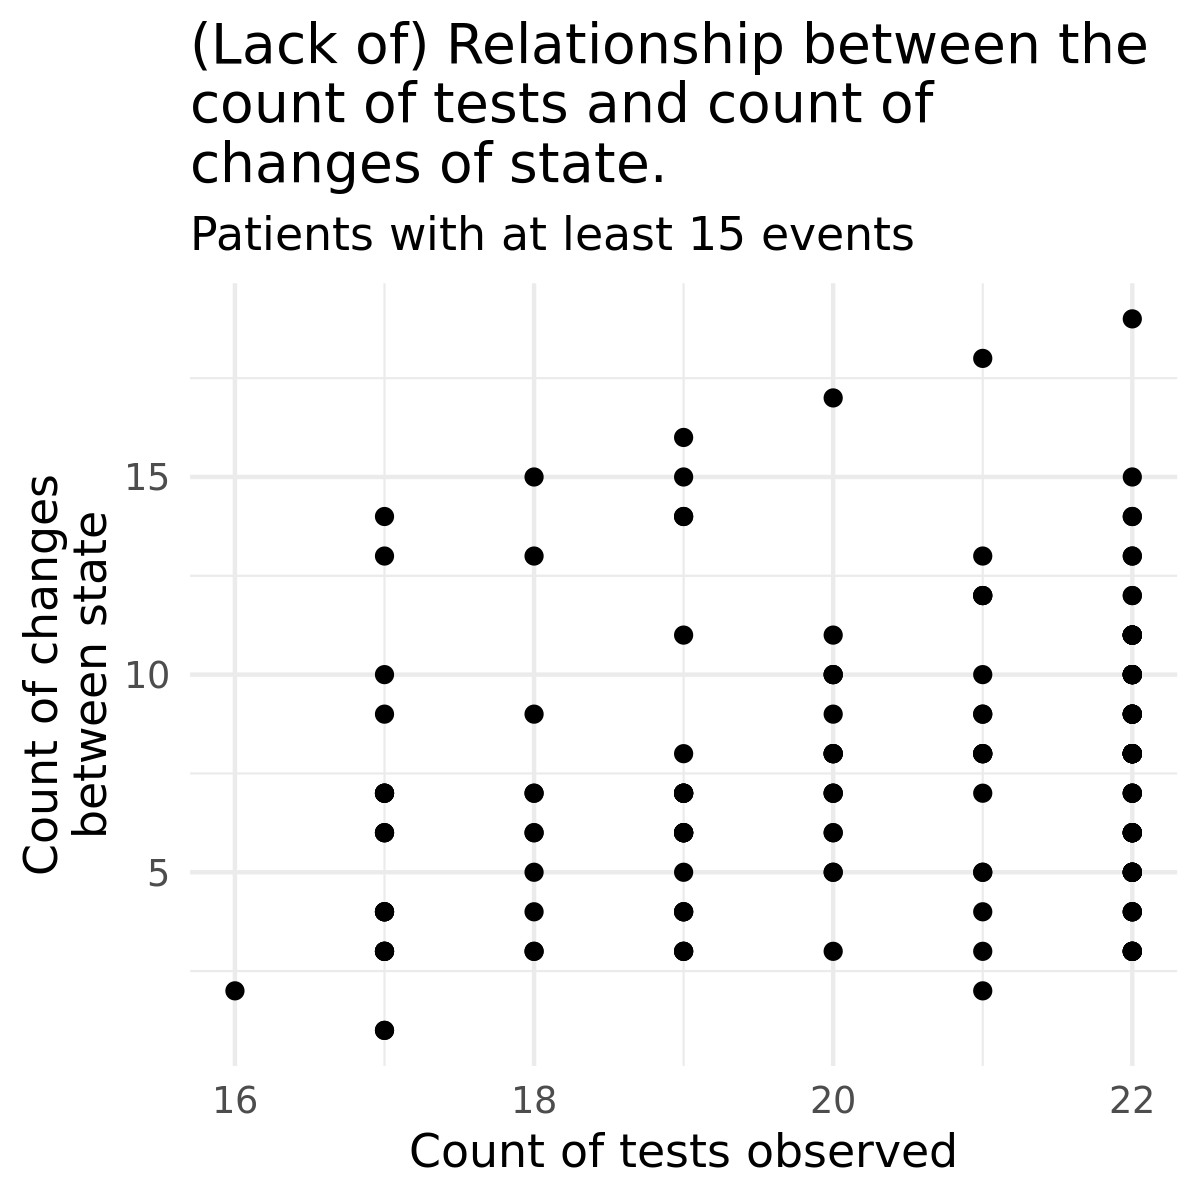

In [121]:
options( repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300 )

fnc__plotcountandchanges( pids = pids_atLeast_5, dataset.name = "Patients with at least 5 events" )
ggsave(
    filename = "(Lack of) Relationship between the count of tests and\ncount of changes of state, 5 or more tests.jpg"
    ,width = 10
    ,height = 10
    ,dpi = 300
    ,units = "cm"
)

fnc__plotcountandchanges( pids = pids_atLeast_10, dataset.name = "Patients with at least 10 events" )
ggsave(
    filename = "(Lack of) Relationship between the count of tests and\ncount of changes of state, 10 or more tests.jpg"
    ,width = 10
    ,height = 10
    ,dpi = 300
    ,units = "cm"
)

fnc__plotcountandchanges( pids = pids_atLeast_15, dataset.name = "Patients with at least 15 events" )
ggsave(
    filename = "(Lack of) Relationship between the count of tests and\ncount of changes of state, 15 or more tests.jpg"
    ,width = 10
    ,height = 10
    ,dpi = 300
    ,units = "cm"
)

## Changing the look-back window to look at prescriptions instead of chronological time.

Run the portion of code that gets us up to the point where the look-back window is applied.

In [8]:

####################
# Format the data. #
####################
# I create the simplified dataframe object from the first iteration.
df_log_PandT_longFormat_simplified <-
    df_log_PandT_longFormat %>%
    # Remove the numbers in the event name.
    dplyr::mutate_at(
        .vars = vars( event_name )
        ,.funs = ~ gsub( "_*[0-9]", "", . )
    )

# Convert to factor. # This becomes too unwieldy if I don't substantially amalgamate the drugs.
if( ( df_log_PandT_longFormat_simplified %>% dplyr::select( event_value ) %>% unique() %>% nrow() ) < 36 )
    {
    df_log_PandT_longFormat_simplified <-
        df_log_PandT_longFormat_simplified %>%
        dplyr::mutate(
            event_value = 
                    factor(
                        event_value
                        ,levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull()
                    )
            )
    } else { 
    message("\nNOTE: Prescriptions were not converted to factor type because there are too many.\n         Consider amalgamating them.")
    }

# Before I can begin analysing the data, I need to define the strata proposed by the Clinical Review Board.
# The stratifications were:
# - H.M.A.: Four strata defined by combinations of {'Expected', 'Shorter-than-expected'} testing intervals
#   and {'No observed change', 'Observed change'} in prescriptions. The H.M.A. acronym derives from the three
#   strata: (0,0)-Hold; (1,0)-Monitor; (0 or 1, 1)-Adjust.
# - Tests-and-Interventions: Twelve strata defined by combinations of the test statuses and whether the patient
#   is on one, two or three medications simulatneously.
# - Multimorbidity: Two strata defined by whether or not there is a record for at least one of the
#   multimorbidity diagnositic codes.
#
# The first thing I do is to add a variable that indicates the patient-specific test interval. This will be
# handy for bounding the variables I need to create.
                      
# Create a variable that indicates patient-specific test interval.
df_log_PandT_longFormat_simplified_StrataLabels <-
    df_log_PandT_longFormat_simplified %>%
    dplyr::group_by( person_id ) %>%
    dplyr::arrange( start_dttm, .by_group = TRUE ) %>%
    dplyr::mutate(
        idx_test_interval = 0 + cumsum( stringr::str_detect( event_value, pattern = "Test" ) )
    ) %>% 
    dplyr::ungroup() %>%
    # Remove any calculated `idx_test_interval` for which the `event_value` is "Unobserved".
    dplyr::mutate(
        idx_test_interval =
            dplyr::if_else( event_value == "Unobserved", NA_integer_, idx_test_interval )
    ) %>%
    # Tidy up.
    dplyr::distinct() %>%
    dplyr::arrange( person_id, start_dttm )


# Append an age column.
# ## For some unknown reason, I have to reload `r_tbl_srpatient` or the `DateBirth` field isn't recognised in functions like `colnames()` and `dplyr::distinct`
# ## despite clearly showing up when `r_tbl_srpatient` is printed to screen. Figure that one out!
r_tbl_srpatient <- dplyr::tbl( con, sql( paste0( "SELECT * FROM ", project_id, ".cb_SRPatient" ) ) )
df_age <-
    r_tbl_srpatient %>%
    # Select only those patients in whom we are interested.
    dplyr::inner_join( qry_records_with_T2DM_diagnoses, by = join_by( person_id ) ) %>%
    dplyr::distinct( person_id, DateBirth ) %>%
    dplyr::collect() %>%
    tidyr::separate(
        col = DateBirth
        ,sep = 4
        ,into = c( "birth_year", "birth_month" )
    ) %>%
    dplyr::mutate(
        DOB = 
            dplyr::if_else(
                is.na( birth_year )
                ,NA
                ,ISOdate( year = birth_year, month = birth_month, day = 1, hour = 0 )
            )
    ) %>%
    # If there are multiple dates of death, chose the earliest one.
    dplyr::group_by( person_id ) %>%
    dplyr::mutate( DOB = min( DOB, na.rm = TRUE ) ) %>%
    dplyr::ungroup() %>% 
    tidyr::drop_na() %>%
    # Tidy up.
    dplyr::distinct( person_id, DOB ) %>%
    dplyr::arrange( person_id ) %>%
    suppressWarnings() 

df_log_PandT_longFormat_simplified_StrataLabels <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    dplyr::left_join(
        df_age
        ,by = join_by( person_id )
        ,relationship = 'many-to-one'
    ) %>%
    dplyr::mutate(
        Age = lubridate::interval( DOB, start_dttm ) / lubridate::years( 1 )
    )


# Include the date of diagnosis.
df_log_PandT_longFormat_simplified_StrataLabels <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    dplyr::group_by( person_id ) %>%
    dplyr::group_modify( ~ tibble::add_row( .x ), .by = person_id ) %>% 
    dplyr::left_join( qry_records_with_T2DM_diagnoses %>% collect(), by = join_by( person_id ) ) %>%
    dplyr::mutate( start_dttm = if_else( is.na( start_dttm ), date_diagnosis , start_dttm ) ) %>%
    dplyr::arrange( person_id, start_dttm, .group_by = TRUE ) %>%
    dplyr::mutate(
        end_dttm = dplyr::if_else( is.na( end_dttm ), lead( start_dttm ), end_dttm )
        ,event_name = dplyr::if_else( is.na( event_value ), "diagnosis", event_name )
    ) %>%
    dplyr::ungroup() 


#########################
# H.M.A. stratification #
#########################
#
# The two components of this stratification are the testing interval and the change in prescription. The testing
# interval requries me to create a variable indicating that the inter-test duration was between
# `val_testing_interval_LB` and `val_testing_interval_UB`. The change-in-prescription criterion refers to 
# whether a new medication-dose set was prescribed, where "new" means not seen in the previous three months.
#
# The first thing is to calculate the inter-test duration.
                      
df_inter_test_duration <-
    qry_log_test_longFormat %>%
    dplyr::collect() %>%
    # Include the date of diagnosis.
    dplyr::group_by( person_id ) %>%
    dplyr::group_modify( ~ tibble::add_row( .x ), .by = person_id ) %>% 
    dplyr::left_join( qry_records_with_T2DM_diagnoses %>% collect(), by = join_by( person_id ) ) %>%
    dplyr::mutate( start_dttm = if_else( is.na( start_dttm ), date_diagnosis , start_dttm ) ) %>%
    dplyr::arrange( person_id, start_dttm, .group_by = TRUE ) %>%
    dplyr::mutate(
        end_dttm = dplyr::if_else( is.na( end_dttm ), lead( start_dttm ), end_dttm )
        ,event_name = dplyr::if_else( is.na( event_value ), "diagnosis", event_name )
    ) %>%
    dplyr::ungroup() %>%
    # Calculate the duration between each test and the next.
    dplyr::mutate( inter_test_duration_cont = lubridate::interval( start_dttm, end_dttm  ) %>% `/`( months(1) ) ) %>% # So, `inter_test_duration` is the duration *to* the next rather than *since* the previous.
    # Create a discretised version of the inter-test duration variable.
    dplyr::mutate(
        inter_test_duration_discr =
            dplyr::if_else(
                inter_test_duration_cont < val_testing_interval_UB
                ,"Shorter than expected"
                ,"As expected"
            )
        ,inter_test_duration_discr = 
            dplyr::if_else(
                inter_test_duration_cont < val_testing_interval_LB
                ,"Not applicable"
                ,inter_test_duration_discr
            )
    ) %>% 
    # Make any same-day tests or anomalies = NA.
    dplyr::mutate(
        inter_test_duration_discr =
             dplyr::if_else(
                 is.na( inter_test_duration_cont )
                 ,"Not applicable"
                 ,inter_test_duration_discr
             )
    ) %>%
    # Tidy up.
    arrange( person_id, start_dttm ) %>%
    dplyr::select( c( person_id, start_dttm, inter_test_duration_cont, inter_test_duration_discr ) ) %>% 
    dplyr::distinct() %>%
    dplyr::arrange( person_id, start_dttm )


# Add the inter-test duration variables to the dataframe.
df_log_PandT_longFormat_simplified_StrataLabels <-
    # Join the data.frame with the variables indicating the inter-test duration.
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    dplyr::left_join(
        df_inter_test_duration 
        ,by = join_by( person_id, start_dttm )
        ,relationship = "many-to-many"
        # The `relationship` argument is needed because a warning is raised for the situations
        # where multiple prescriptions are given on the same day.
    ) %>%
    # Fill in the values of the inter-test variables into subsequent rows until a new value is given.
    dplyr::group_by( person_id ) %>%
    dplyr::arrange( start_dttm, .group_by = TRUE ) %>%
    tidyr::fill( inter_test_duration_cont ) %>%
    tidyr::fill( inter_test_duration_discr ) %>%
    dplyr::mutate( inter_test_duration_cont = dplyr::if_else( inter_test_duration_discr == "Not applicable", NA_real_, inter_test_duration_cont ) ) %>%
    dplyr::ungroup()


In [448]:
# Define a new look-back parameter for the number of prescriptions.
HMA_adjust_lookBack_count <- 2

# Do the same initial processing that brings us up to the point where the look-back window is applied.
df <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    # Create new columns that contain the test events and the prescription events.
    dplyr::select( person_id, start_dttm, event_value, idx_test_interval ) %>%
    dplyr::filter( !stringr::str_detect( event_value, pattern = "Test") ) %>%
    dplyr::filter( !stringr::str_detect( event_value, pattern = "Unobserved") ) %>%
    dplyr::mutate( meds_only = as.character( event_value ) ) %>%
    # Remove duplicated prescriptions occuring on the same day.
    dplyr::distinct( person_id, start_dttm, meds_only ) %>%
    dplyr::arrange( person_id, start_dttm )

df %>% head()

person_id,start_dttm,meds_only
<chr>,<dttm>,<chr>
000CB46DD3209178B013CD5DEAA574F0D6724028CAC8EFA5BC7C2DE015C01185,2000-08-04 15:50:53,Gliclazide 80mg
000CB46DD3209178B013CD5DEAA574F0D6724028CAC8EFA5BC7C2DE015C01185,2000-09-15 16:22:55,Gliclazide 80mg
000CB46DD3209178B013CD5DEAA574F0D6724028CAC8EFA5BC7C2DE015C01185,2000-10-17 12:13:30,Gliclazide 80mg
000CB46DD3209178B013CD5DEAA574F0D6724028CAC8EFA5BC7C2DE015C01185,2000-11-20 17:41:38,Gliclazide 80mg
000CB46DD3209178B013CD5DEAA574F0D6724028CAC8EFA5BC7C2DE015C01185,2001-02-06 13:15:10,Gliclazide 80mg
000CB46DD3209178B013CD5DEAA574F0D6724028CAC8EFA5BC7C2DE015C01185,2001-03-14 17:19:36,Gliclazide 80mg


The following code is a refactoring of the look-back code for chronological time. Here, I lok=ok back through the index of prescription, instead. I have not refactored the code for the chronological look back. 

In [449]:
df %>%
# Create an incremented index for prescriptions so that same-day drugs are marked as the same prescription.
dplyr::group_by( person_id, start_dttm ) %>%
dplyr::mutate( prescription_index = cur_group_id() ) %>%
dplyr::ungroup() %>%
dplyr::select( - start_dttm ) %>%
# Create a nested list of drugs prescribed on a given day.
tidyr::nest( .by = person_id, .key = "meds_as_nested_list" ) %>%
dplyr::mutate(
        meds_in_current_prescription = 
            lapply(
                meds_as_nested_list
                ,function(x) slider::slide_index(.x = x$meds_only, .i = x$prescription_index, .f = ~.x, .before = 0 ) %>% array()
                )
) %>%
tidyr::unnest( cols = c( meds_as_nested_list, meds_in_current_prescription ) ) %>%
dplyr::mutate( meds_in_current_prescription = lapply( X = meds_in_current_prescription, FUN = \(x) sort( unique( unlist(x) ) ) ) ) %>%
# Remove `meds_only` because it is no longer required.
dplyr::select( -meds_only ) %>%
dplyr::distinct() %>% 
# Create a nested list of drugs prescribed in prescriptions within the look-back window. The `purrr:map2()` bit
# removes the current prescription from the list.
tidyr::nest( .by = person_id, .key = "meds_as_nested_list" ) %>%
dplyr::mutate(
    meds_in_lookback_prescriptions = 
        lapply(
            meds_as_nested_list
            ,function(x)
                purrr::map2(
                    slider::slide_index( .x = seq_along( x$meds_in_current_prescription ), .i = x$prescription_index, .f = ~.x, .before = HMA_adjust_lookBack_count )
                    ,seq_along( x$meds_in_current_prescription )
                    ,~x$meds_in_current_prescription[ setdiff( .x, .y ) ]
                )
            )
) %>%
tidyr::unnest( cols = c( meds_as_nested_list, meds_in_lookback_prescriptions ) ) %>%
# Unlist the drugs that are included in the look-back window, and keep and sort only unique values.
dplyr::mutate(
    meds_in_lookback_prescriptions = lapply( X = meds_in_lookback_prescriptions, FUN = \(x) sort( unique( unlist(x) ) ) )
) %>%
as.data.frame() %>% 
# Alert if there is anything in the current prescription that was not in the look-back prescriptions.
dplyr::mutate(
    HMA = purrr::map2( meds_in_current_prescription, meds_in_lookback_prescriptions, setdiff )
) %>%
dplyr::rowwise() %>%
dplyr::mutate( HMA = dplyr::if_else( !all( HMA == "" ), 'Adjust', 'Not adjust' ) ) %>%
dplyr::ungroup() %>%
as.data.frame()

person_id,prescription_index,meds_in_current_prescription,meds_in_lookback_prescriptions,HMA
<chr>,<int>,<list>,<list>,<chr>
000CB46DD3209178B013CD5DEAA574F0D6724028CAC8EFA5BC7C2DE015C01185,1,Gliclazide 80mg,NULL,Adjust
000CB46DD3209178B013CD5DEAA574F0D6724028CAC8EFA5BC7C2DE015C01185,2,Gliclazide 80mg,Gliclazide 80mg,Not adjust
000CB46DD3209178B013CD5DEAA574F0D6724028CAC8EFA5BC7C2DE015C01185,3,Gliclazide 80mg,Gliclazide 80mg,Not adjust
000CB46DD3209178B013CD5DEAA574F0D6724028CAC8EFA5BC7C2DE015C01185,4,Gliclazide 80mg,Gliclazide 80mg,Not adjust
000CB46DD3209178B013CD5DEAA574F0D6724028CAC8EFA5BC7C2DE015C01185,5,Gliclazide 80mg,Gliclazide 80mg,Not adjust
000CB46DD3209178B013CD5DEAA574F0D6724028CAC8EFA5BC7C2DE015C01185,6,Gliclazide 80mg,Gliclazide 80mg,Not adjust
000CB46DD3209178B013CD5DEAA574F0D6724028CAC8EFA5BC7C2DE015C01185,7,Gliclazide 80mg,Gliclazide 80mg,Not adjust
000CB46DD3209178B013CD5DEAA574F0D6724028CAC8EFA5BC7C2DE015C01185,8,Gliclazide 80mg,Gliclazide 80mg,Not adjust
000CB46DD3209178B013CD5DEAA574F0D6724028CAC8EFA5BC7C2DE015C01185,9,Gliclazide 80mg,Gliclazide 80mg,Not adjust


# GGanimate fun

In [ ]:
options( repr.plot.width = 5, repr.plot.height = 25, repr.plot.res = 300 )

df_log_PandT_longFormat_simplified_StrataLabels %>%
dplyr::select( person_id, idx_test_interval, HMA, HbA1c ) %>%
dplyr::filter( !is.na( HbA1c ) ) %>%
dplyr::group_by( person_id ) %>%
dplyr::mutate( delta_HbA1c = lead( HbA1c ) - HbA1c ) %>%
tidyr::drop_na() %>%
ggplot( aes( group = HMA, colour = HMA, fill = HMA ) ) +
geom_histogram( aes( x = delta_HbA1c ), alpha = 0.2 ) +
labs( x = "\u0394 HbA1c") +
scale_colour_manual(
    values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
) +
scale_fill_manual(
    values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
    ,labels = c( "Hold", "Monitor", "Adjust", "NA" )
    ,name = NULL
) +
scale_x_continuous( sec.axis = dup_axis() ) +
guides( colour = 'none' ) +
facet_wrap(~ idx_test_interval , ncol = 1 ) +
theme_bw() +
theme( legend.position = "top", axis.text.y = element_blank() ) +

gganimate::transition_time( idx_test_interval ) + 
ggtitle(
    'Now showing {closest_state}.'
    ,subtitle = 'Inter-test interval {frame} of {nframes}.'
) +
gganimate::ease_aes( 'linear' )

gganimate::anim_save("test.gif")

In [132]:
# Load necessary packages
pacman::p_load(ggplot2,gganimate)

# Prepare the data
data("mpg")

# Base plot using geom_density, facetted by 'class'
p <- ggplot(mpg, aes(x = hwy, fill = class)) +
  geom_density(alpha = 0.7) +
  labs(title = 'Vehicle Class: {closest_state}', x = 'Highway MPG', y = 'Density') +
  theme_minimal() +
  theme(legend.position = "none")

# Animate: transition through the 'class' variable (used for faceting)
animated_plot <- p +
  transition_states(class, transition_length = 2, state_length = 1) +
  enter_fade() + exit_fade()

# Render the animation
animate(animated_plot, width = 600, height = 400, fps = 10, duration = 10, renderer = gifski_renderer())


Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘classInt’, ‘s2’, ‘units’, ‘sf’, ‘lpSolve’, ‘transformr’


Warning message in utils::install.packages(package, ...):
“installation of package ‘s2’ had non-zero exit status”
Warning message in utils::install.packages(package, ...):
“installation of package ‘units’ had non-zero exit status”
Warning message in utils::install.packages(package, ...):
“installation of package ‘lpSolve’ had non-zero exit status”
Warning message in utils::install.packages(package, ...):
“installation of package ‘e1071’ had non-zero exit status”
Warning message in utils::install.packages(package, ...):
“installation of package ‘classInt’ had non-zero exit status”
Warning message in utils::install.packages(package, ...):
“installation of package ‘sf’ had non-zero exit status”
Warning message in utils::install.packages(package, ...):
“installation of package ‘transformr’ had non-zero ex